In [1]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d

import SolveLinSys
import time
from supportfunctions import PDESolver_2d, finiteDiff
import global_parameters as gp
from utilities import dLambda, ddLambda, weightOfPi, relativeEntropy, weightPI, damageDrift, zDrift

In [2]:
@njit
def derivative_1d(data, order, h_data, upwind=True):
    num, = data.shape
    ddata = np.zeros_like(data)
    if order == 1:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+1]-data[i])/h_data
            elif i == num-1:
                ddata[i] = (data[i]-data[i-1])/h_data
            else: 
                if upwind == True:
                    ddata[i] = (data[i]-data[i-1])/h_data
                else:
                    ddata[i] = (data[i+1]-data[i-1])/(2*h_data)
    elif order == 2:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+2]-2*data[i+1] + data[i])/(h_data**2)
            elif i == num -1:
                ddata[i] = (data[i]-2*data[i-1] + data[i-2])/(h_data**2)
            else:
                ddata[i] = (data[i+1]- 2*data[i] + data[i-1])/(h_data**2)
    
    return ddata

In [5]:
@njit
def get_coeff(A, Bx, Cxx, D, x_grid, ϕ_prev, ϵ, boundspec):
    dx = x_grid[1] - x_grid[0]
    numx = len(x_grid)
    LHS = np.zeros((numx, numx))
    RHS = -1/ϵ*ϕ_prev - D
    for i in range(numx):
        LHS[i,i] += - 1/ϵ + A[i]
        if i == 0:
            LHS[i,i] += - 1/dx*Bx[i]
            LHS[i,i+1] += 1/dx*Bx[i]
        elif i == numx-1:
            if boundspec[0] == True:
                LHS[i,i] = 1
                RHS[i] = boundspec[1]
            else:
                LHS[i,i] += 1/dx*Bx[i]
                LHS[i,i-1] += -1/dx*Bx[i]
        else:
            LHS[i,i+1] += Bx[i]*(1./dx)*(Bx[i]>0) + Cxx[i]/(dx**2)
            LHS[i,i] += Bx[i]*((-1/dx)*(Bx[i]>0) + (1/dx)*(Bx[i]<0)) - 2*Cxx[i]/(dx**2)
            LHS[i,i-1] += Bx[i]*(-1/dx)*(Bx[i]<0) + Cxx[i]/(dx**2)
    return LHS, RHS

In [6]:
def solve_ode( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec):
    LHS, RHS = get_coeff( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
#     phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [7]:
def false_transient_1d(
    y_grid, z, 
    dmg_params, model_params, bounded=False, bound_var=0, 
    epsilon=0.5, tol = 1e-8, max_iter=10_000,
):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numy, = y_grid.shape
    hy = y_grid[1] - y_grid[0]
    dlambda = gamma_1 + gamma_2*y_grid\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_grid-gamma_bar)*(y_grid>gamma_bar)
    # initiate v and control
    ems = -delta*eta/((eta-1)*dlambda*z)
    error = 1
    episode = 0
    v0 = - delta*eta*y_grid
    
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivative_1d(v0,1,hy, upwind=True)
        # control
        ems_new = -delta*eta/(v0_dy*z + v_n*dlambda*z)
        ems_new[ems_new<=0] = 1e-15
        ems = ems_new*.5 + ems*.5
        A = -delta*np.ones(y_grid.shape)
        By = z*ems
        Cyy = np.zeros(y_grid.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z*ems
        # solve for ODE
        phi_grid = solve_ode(y_grid, A, By, Cyy, D, v0, bound_var, bounded, epsilon)
        phi_grid2 = false_transient_one_iteration_python(
            A, By, Cyy, D, v0, epsilon, hy, (0,bound_var), (False, bounded))
        diff = np.max(abs(phi_grid - phi_grid2))
        rhs = A*phi_grid + By*v0_dy + D
        rhs_error = np.max(abs(rhs))
        error = np.max(abs((phi_grid-v0)/epsilon))
        v0 = phi_grid
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}\t diff: {:.12f}'.format(episode,error,rhs_error,diff))
    return v0, ems

In [8]:
δ = 0.01
η = 0.032
μ = 1.86/1000
ȳ = 2

numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

γ1 = 0.00017675
γ2 = 2*0.0022
γ2p = np.array([0, 2*0.0197])
γbar = 2
dmg_weight = np.array([1, 0])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

In [9]:
ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0015507701573692011,	 ft error: 0.0013554655757295271
episode: 2,	 ode error: 0.0013944201792057969,	 ft error: 0.0012890766500556182
episode: 3,	 ode error: 0.001299636484308969,	 ft error: 0.0012345215390425718
episode: 4,	 ode error: 0.0012367923884590314,	 ft error: 0.0011912406605538856
episode: 5,	 ode error: 0.0011907292220521152,	 ft error: 0.001156075810254932
episode: 6,	 ode error: 0.0011544420579144624,	 ft error: 0.001126573270437606
episode: 7,	 ode error: 0.0011244139906146226,	 ft error: 0.0011011294005619525
episode: 8,	 ode error: 0.001098698555369187,	 ft error: 0.0010787079975184757
episode: 9,	 ode error: 0.0010761267737521489,	 ft error: 0.0010586228265494282
episode: 10,	 ode error: 0.0010559495177003297,	 ft error: 0.0010403707283219107
episode: 11,	 ode error: 0.001037656909618132,	 ft error: 0.001023622140226138
episode: 12,	 ode error: 0.0010208887346232292,	 ft error: 0.0010081205349473732
episode: 13,	 ode error: 0.0010053809639429

episode: 204,	 ode error: 0.0003289096571675173,	 ft error: 0.0003279488333308064
episode: 205,	 ode error: 0.00032693793506273136,	 ft error: 0.000327765703783701
episode: 206,	 ode error: 0.0003262350837031383,	 ft error: 0.000324916446406189
episode: 207,	 ode error: 0.00032394363176799635,	 ft error: 0.00032356060023612987
episode: 208,	 ode error: 0.00032258615496991855,	 ft error: 0.00032322210642715216
episode: 209,	 ode error: 0.00032182441673376876,	 ft error: 0.0003208757087109123
episode: 210,	 ode error: 0.0003198879911646686,	 ft error: 0.00032074364262021004
episode: 211,	 ode error: 0.0003192176264360067,	 ft error: 0.00031793448668951396
episode: 212,	 ode error: 0.0003169822190987005,	 ft error: 0.0003166123579376642
episode: 213,	 ode error: 0.0003156587139499785,	 ft error: 0.000316289808649529
episode: 214,	 ode error: 0.0003149168661424576,	 ft error: 0.00031400537790928407
episode: 215,	 ode error: 0.0003130383169564608,	 ft error: 0.0003138438228269166
episode: 2

episode: 423,	 ode error: 0.0001352038427092035,	 ft error: 0.0001350995781271754
episode: 424,	 ode error: 0.00013467150835877234,	 ft error: 0.00013459161249884205
episode: 425,	 ode error: 0.00013416417510914245,	 ft error: 0.00013406348988833733
episode: 426,	 ode error: 0.00013363856181841064,	 ft error: 0.0001335574692385803
episode: 427,	 ode error: 0.00013313336147526586,	 ft error: 0.00013303577929298557
episode: 428,	 ode error: 0.00013261398493505665,	 ft error: 0.00013253210580127517
episode: 429,	 ode error: 0.0001321112816705639,	 ft error: 0.00013201640362811112
episode: 430,	 ode error: 0.00013159773191910964,	 ft error: 0.00013151540494189357
episode: 431,	 ode error: 0.0001310978219191259,	 ft error: 0.00013100531556081246
episode: 432,	 ode error: 0.0001305897528420879,	 ft error: 0.00013050725570439942
episode: 433,	 ode error: 0.00013009287424284712,	 ft error: 0.00013000246371022245
episode: 434,	 ode error: 0.00012958999415769068,	 ft error: 0.0001295075528059732

episode: 644,	 ode error: 5.89116466497184e-05,	 ft error: 5.8886282061007544e-05
episode: 645,	 ode error: 5.869403785845734e-05,	 ft error: 5.866881929749342e-05
episode: 646,	 ode error: 5.8477243721116235e-05,	 ft error: 5.845217047990385e-05
episode: 647,	 ode error: 5.826126100805609e-05,	 ft error: 5.8236332385654586e-05
episode: 648,	 ode error: 5.804608650706016e-05,	 ft error: 5.80213018093236e-05
episode: 649,	 ode error: 5.7831717022826146e-05,	 ft error: 5.780707556265104e-05
episode: 650,	 ode error: 5.761814937707815e-05,	 ft error: 5.759365047386852e-05
episode: 651,	 ode error: 5.740538040831331e-05,	 ft error: 5.738102338806913e-05
episode: 652,	 ode error: 5.719340697143982e-05,	 ft error: 5.716919116688368e-05
episode: 653,	 ode error: 5.6982225937989906e-05,	 ft error: 5.6958150687948704e-05
episode: 654,	 ode error: 5.677183419562268e-05,	 ft error: 5.6747898845438405e-05
episode: 655,	 ode error: 5.656222864815815e-05,	 ft error: 5.6538432549070136e-05
episode: 6

episode: 867,	 ode error: 2.5886300732065473e-05,	 ft error: 2.5882236098992428e-05
episode: 868,	 ode error: 2.579127917142171e-05,	 ft error: 2.5787274340767035e-05
episode: 869,	 ode error: 2.5696608362737105e-05,	 ft error: 2.569266310708159e-05
episode: 870,	 ode error: 2.5602287002287932e-05,	 ft error: 2.5598401094950596e-05
episode: 871,	 ode error: 2.550831379110317e-05,	 ft error: 2.5504487006477082e-05
episode: 872,	 ode error: 2.5414687435341803e-05,	 ft error: 2.5410919548413125e-05
episode: 873,	 ode error: 2.5321406645812967e-05,	 ft error: 2.531769743259934e-05
episode: 874,	 ode error: 2.5228470138222267e-05,	 ft error: 2.5224819375710417e-05
episode: 875,	 ode error: 2.5135876633134054e-05,	 ft error: 2.513228409900074e-05
episode: 876,	 ode error: 2.5043624855907126e-05,	 ft error: 2.5040090328720677e-05
episode: 877,	 ode error: 2.4951713536597807e-05,	 ft error: 2.4948236795792798e-05
episode: 878,	 ode error: 2.486014141019294e-05,	 ft error: 2.4856722236020017e-0

episode: 1090,	 ode error: 1.1420362835357187e-05,	 ft error: 1.1425303865173857e-05
episode: 1091,	 ode error: 1.1378617230220532e-05,	 ft error: 1.1383583876552658e-05
episode: 1092,	 ode error: 1.133702494125863e-05,	 ft error: 1.1342017107104918e-05
episode: 1093,	 ode error: 1.1295585402384262e-05,	 ft error: 1.1300602990963842e-05
episode: 1094,	 ode error: 1.1254298049373523e-05,	 ft error: 1.1259340964413686e-05
episode: 1095,	 ode error: 1.1213162320164406e-05,	 ft error: 1.1218230465889767e-05
episode: 1096,	 ode error: 1.1172177654923806e-05,	 ft error: 1.1177270935608385e-05
episode: 1097,	 ode error: 1.1131343495696675e-05,	 ft error: 1.1136461816214454e-05
episode: 1098,	 ode error: 1.1090659286836662e-05,	 ft error: 1.109580255236516e-05
episode: 1099,	 ode error: 1.105012447455238e-05,	 ft error: 1.1055292590568071e-05
episode: 1100,	 ode error: 1.1009738507148097e-05,	 ft error: 1.1014931379551193e-05
episode: 1101,	 ode error: 1.0969500835099843e-05,	 ft error: 1.0974

episode: 1315,	 ode error: 5.017525397356653e-06,	 ft error: 5.026350421780124e-06
episode: 1316,	 ode error: 4.999248983498855e-06,	 ft error: 5.008084919313113e-06
episode: 1317,	 ode error: 4.981039387994858e-06,	 ft error: 4.989886193985475e-06
episode: 1318,	 ode error: 4.962896365475508e-06,	 ft error: 4.971754000437922e-06
episode: 1319,	 ode error: 4.944819671156685e-06,	 ft error: 4.953688094005057e-06
episode: 1320,	 ode error: 4.926809061152099e-06,	 ft error: 4.935688231247348e-06
episode: 1321,	 ode error: 4.908864292695546e-06,	 ft error: 4.917754169187864e-06
episode: 1322,	 ode error: 4.890985123596754e-06,	 ft error: 4.899885666144929e-06
episode: 1323,	 ode error: 4.873171312885717e-06,	 ft error: 4.882082480945719e-06
episode: 1324,	 ode error: 4.855422620185707e-06,	 ft error: 4.864344373758933e-06
episode: 1325,	 ode error: 4.8377388063474205e-06,	 ft error: 4.846671105215861e-06
episode: 1326,	 ode error: 4.820119632726683e-06,	 ft error: 4.829062437150533e-06
epi

episode: 1539,	 ode error: 2.217882764619754e-06,	 ft error: 2.228357888188944e-06
episode: 1540,	 ode error: 2.209821890264592e-06,	 ft error: 2.2203016807748055e-06
episode: 1541,	 ode error: 2.201790351792545e-06,	 ft error: 2.212274791644579e-06
episode: 1542,	 ode error: 2.1937880418841866e-06,	 ft error: 2.204277113337927e-06
episode: 1543,	 ode error: 2.185814853271047e-06,	 ft error: 2.196308538972754e-06
episode: 1544,	 ode error: 2.177870679709662e-06,	 ft error: 2.1883689621295574e-06
episode: 1545,	 ode error: 2.1699554148408825e-06,	 ft error: 2.1804582765507416e-06
episode: 1546,	 ode error: 2.1620689528347586e-06,	 ft error: 2.172576376580082e-06
episode: 1547,	 ode error: 2.154211188366579e-06,	 ft error: 2.164723156746392e-06
episode: 1548,	 ode error: 2.1463820162733946e-06,	 ft error: 2.156898512249243e-06
episode: 1549,	 ode error: 2.1385813320827854e-06,	 ft error: 2.149102338403856e-06
episode: 1550,	 ode error: 2.1308090313544234e-06,	 ft error: 2.141334530988044

episode: 1762,	 ode error: 9.846379874944204e-07,	 ft error: 9.958167505874638e-07
episode: 1763,	 ode error: 9.810559289827412e-07,	 ft error: 9.922366945673093e-07
episode: 1764,	 ode error: 9.774868426611159e-07,	 ft error: 9.886696033384323e-07
episode: 1765,	 ode error: 9.739306814417767e-07,	 ft error: 9.85115429554447e-07
episode: 1766,	 ode error: 9.703873981651819e-07,	 ft error: 9.815741261465227e-07
episode: 1767,	 ode error: 9.668569458372387e-07,	 ft error: 9.780456462771259e-07
episode: 1768,	 ode error: 9.633392778033182e-07,	 ft error: 9.745299431549819e-07
episode: 1769,	 ode error: 9.598343473961064e-07,	 ft error: 9.71026970196983e-07
episode: 1770,	 ode error: 9.563421081816093e-07,	 ft error: 9.675366810513175e-07
episode: 1771,	 ode error: 9.528625140047984e-07,	 ft error: 9.640590295280824e-07
episode: 1772,	 ode error: 9.493955186620729e-07,	 ft error: 9.605939695530217e-07
episode: 1773,	 ode error: 9.459410763568415e-07,	 ft error: 9.571414551906576e-07
episod

episode: 1986,	 ode error: 9.990691207338847e-07,	 ft error: 4.4552751467252794e-07
episode: 1987,	 ode error: 1.0006509830639198e-06,	 ft error: 4.4393569353003614e-07
episode: 1988,	 ode error: 1.0022271493795483e-06,	 ft error: 4.423496057874103e-07
episode: 1989,	 ode error: 1.0037976403187753e-06,	 ft error: 4.4076923053545014e-07
episode: 1990,	 ode error: 1.0053624764691906e-06,	 ft error: 4.3919454721190004e-07
episode: 1991,	 ode error: 1.006921678254019e-06,	 ft error: 4.376255350694673e-07
episode: 1992,	 ode error: 1.0084752662978215e-06,	 ft error: 4.3606217349963694e-07
episode: 1993,	 ode error: 1.0100232607297872e-06,	 ft error: 4.3450444212519057e-07
episode: 1994,	 ode error: 1.0115656820409036e-06,	 ft error: 4.329523204301319e-07
episode: 1995,	 ode error: 1.013102550307776e-06,	 ft error: 4.3140578819914993e-07
episode: 1996,	 ode error: 1.0146338856369336e-06,	 ft error: 4.298648249393781e-07
episode: 1997,	 ode error: 1.0161597081551803e-06,	 ft error: 4.28329410

episode: 2208,	 ode error: 1.2412941887357878e-06,	 ft error: 2.0179974679716367e-07
episode: 2209,	 ode error: 1.2420060395687332e-06,	 ft error: 2.0108356861558985e-07
episode: 2210,	 ode error: 1.242715342326538e-06,	 ft error: 2.003699546791286e-07
episode: 2211,	 ode error: 1.2434221063497121e-06,	 ft error: 1.9965889568966205e-07
episode: 2212,	 ode error: 1.2441263406651063e-06,	 ft error: 1.989503824647206e-07
episode: 2213,	 ode error: 1.2448280544321687e-06,	 ft error: 1.9824440579870503e-07
episode: 2214,	 ode error: 1.2455272567828092e-06,	 ft error: 1.9754095655540502e-07
episode: 2215,	 ode error: 1.2462239567538527e-06,	 ft error: 1.9684002564486955e-07
episode: 2216,	 ode error: 1.2469181633656444e-06,	 ft error: 1.961416039308883e-07
episode: 2217,	 ode error: 1.2476098856351687e-06,	 ft error: 1.954456824160289e-07
episode: 2218,	 ode error: 1.248299132437596e-06,	 ft error: 1.9475225194095133e-07
episode: 2219,	 ode error: 1.248985912769853e-06,	 ft error: 1.94061303

episode: 2432,	 ode error: 1.3511714446960265e-06,	 ft error: 9.126570126953097e-08
episode: 2433,	 ode error: 1.351491099572705e-06,	 ft error: 9.094417966389509e-08
episode: 2434,	 ode error: 1.3518096177546953e-06,	 ft error: 9.062380168049315e-08
episode: 2435,	 ode error: 1.3521270033629417e-06,	 ft error: 9.030456322537776e-08
episode: 2436,	 ode error: 1.3524432606337473e-06,	 ft error: 8.998646018147187e-08
episode: 2437,	 ode error: 1.3527583932177291e-06,	 ft error: 8.966948852421701e-08
episode: 2438,	 ode error: 1.3530724056231083e-06,	 ft error: 8.935364411340649e-08
episode: 2439,	 ode error: 1.353385301397828e-06,	 ft error: 8.9038923109519e-08
episode: 2440,	 ode error: 1.3536970849108978e-06,	 ft error: 8.872532121044034e-08
episode: 2441,	 ode error: 1.3540077598915394e-06,	 ft error: 8.841283464603815e-08
episode: 2442,	 ode error: 1.3543173305361573e-06,	 ft error: 8.810145918358714e-08
episode: 2443,	 ode error: 1.3546258007343269e-06,	 ft error: 8.779119105295496e

episode: 2657,	 ode error: 1.4007718974823813e-06,	 ft error: 4.138107444669655e-08
episode: 2658,	 ode error: 1.4009157226327383e-06,	 ft error: 4.123644673411272e-08
episode: 2659,	 ode error: 1.4010590400611927e-06,	 ft error: 4.1092329816638795e-08
episode: 2660,	 ode error: 1.4012018515384634e-06,	 ft error: 4.094872177451414e-08
episode: 2661,	 ode error: 1.401344158898695e-06,	 ft error: 4.0805620919274574e-08
episode: 2662,	 ode error: 1.4014859639359173e-06,	 ft error: 4.066302523864085e-08
episode: 2663,	 ode error: 1.4016272684623738e-06,	 ft error: 4.052093315979703e-08
episode: 2664,	 ode error: 1.4017680741695284e-06,	 ft error: 4.037934267046388e-08
episode: 2665,	 ode error: 1.40190838299626e-06,	 ft error: 4.023825219782544e-08
episode: 2666,	 ode error: 1.4020481965669202e-06,	 ft error: 4.009765984525071e-08
episode: 2667,	 ode error: 1.4021875167172801e-06,	 ft error: 3.9957563762367997e-08
episode: 2668,	 ode error: 1.4023263451643907e-06,	 ft error: 3.981796235323

episode: 2881,	 ode error: 1.4230808728628395e-06,	 ft error: 1.8950260018598307e-08
episode: 2882,	 ode error: 1.423146203283817e-06,	 ft error: 1.888458315650136e-08
episode: 2883,	 ode error: 1.4232113049052848e-06,	 ft error: 1.8819136388126267e-08
episode: 2884,	 ode error: 1.423276178388823e-06,	 ft error: 1.8753918973324346e-08
episode: 2885,	 ode error: 1.423340824760087e-06,	 ft error: 1.8688930102557975e-08
episode: 2886,	 ode error: 1.423405244698763e-06,	 ft error: 1.862416887377094e-08
episode: 2887,	 ode error: 1.423469438973984e-06,	 ft error: 1.855963459307386e-08
episode: 2888,	 ode error: 1.423533408512743e-06,	 ft error: 1.8495326474058753e-08
episode: 2889,	 ode error: 1.4235971538840292e-06,	 ft error: 1.8431243545280473e-08
episode: 2890,	 ode error: 1.4236606761476502e-06,	 ft error: 1.836738520536822e-08
episode: 2891,	 ode error: 1.423723975857525e-06,	 ft error: 1.830375048287684e-08
episode: 2892,	 ode error: 1.4237870539183118e-06,	 ft error: 1.8240338660787

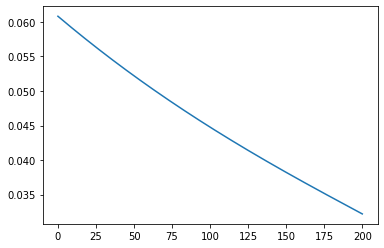

In [11]:
ϕ_low = ϕ
plt.plot(ϕ_low)

# With reserve constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & \quad b \delta\eta \log\tilde e \\
&  + b \frac{\xi_m}{2} h'h + \frac{dV}{dy} \tilde e (\theta + \sigma_y h) - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2\\
& + b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h) + b\frac{1}{2}(\eta -1)(\gamma_2)(\tilde e)^2|\sigma_y|^2 - \ell \tilde e
\end{aligned}
$$

$$
h^* = - \frac{\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)}{b \xi_m} \cdot \tilde e \sigma_y
$$
Plug back into the HJB:
$$
\begin{aligned}
0 = \max_{\tilde e } \quad & b \delta\eta \log \tilde e + \frac{dV}{dy} \tilde e \theta - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2 \\ 
& +  b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot \theta  + b\frac{1}{2}(\eta -1)(\gamma_2)(\tilde e)^2|\sigma_y|^2 \color{red}{ - \ell \tilde e}\\
& -\frac{1}{2b\xi_m}\left(\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)\right)^2 (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$

$$
b \in (0,1]
$$

$$
y: \text{celsius}\quad^oC
$$

$$
    \theta: \quad \text{celsius per gigatonne of carbon}, \quad ^oC/GtC
$$

$$
    \sigma_y = 1.2 \theta:  \quad \text{celsius per gigatonne of carbon}, \quad ^oC/GtC
$$

$$
\tilde e: \quad \text{gigatonne of carbon}, \quad GtC
$$

$$
\gamma_1 = 1.7675\times 10^{-4}
$$

$$
\gamma_2 = 0.0044
$$

First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2} + b(\eta -1) \gamma_2 \right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{dV}{dy}\theta + b(\eta - 1)(\gamma_1 + \gamma_2 y)\theta - \ell \right]\tilde e + b \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}+ b(\eta -1) \gamma_2 \right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{dV}{dy} + b(\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta - \ell
$$ 

$$
C = b \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [327]:
b_grid = np.linspace(1e-10, 1, 100)
y_grid = np.linspace(1e-10, 4, 100)
# mesh grid and construct state space
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

In [523]:
# 2 state HJB with constraints
θ = 1.86/1000
δ = 0.01
η = 0.032

ϵ = 1
# ℓ = 1e-12
ξₘ = 1000
σy = 1.2*θ

γ3_list = np.array([0, 2*0.0197, 2*0.3853])
π_p = np.array([1/3, 1/3, 1/3])
tol = 1e-8
dΛ = γ1 + γ2*y_mat + π_p@γ3_list*(y_mat - ȳ)*(y_mat >ȳ)
ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)

v_dict = dict()
ems_dict = dict()
ℓ_step = 1e-16

for ℓ in [1e-12, 1e-5]:
    episode = 0
    lhs_error = 1
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls

        print(np.min(ems))
        temp = v0_dy + b_mat*(η-1)*dΛ
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2 + b_mat*(η - 1)*ddΛ*σy**2
        b = temp*θ  - ℓ
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 0] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  ems*θ
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) + b_mat*(η-1)*(dΛ*ems*θ + 1/2*ddΛ*ems**2*σy**2)\
        - ℓ*ems - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
              rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    v_dict[ℓ] = v0
    ems_dict[ℓ] = ems

0.3186407160373311
Episode 0: PDE Error: 0.001318976187; False Transient Error: 0.001194224996; Iterations: 1196; CG Error: 0.000000000089
End of PDE solver, takes time: 9792.26844906807
6.754539284663241e-09
Episode 1: PDE Error: 0.001201093337; False Transient Error: 0.001109829247; Iterations: 734; CG Error: 0.000000000092
End of PDE solver, takes time: 9792.38091135025
6.754539284663241e-09
Episode 2: PDE Error: 0.001114939659; False Transient Error: 0.001045846839; Iterations: 486; CG Error: 0.000000000094
End of PDE solver, takes time: 9792.437074899673
6.754539282061156e-09
Episode 3: PDE Error: 0.001049135982; False Transient Error: 0.000994285175; Iterations: 346; CG Error: 0.000000000095
End of PDE solver, takes time: 9792.477550029755
6.7545392803264326e-09
Episode 4: PDE Error: 0.000996431947; False Transient Error: 0.000951101708; Iterations: 267; CG Error: 0.000000000097
End of PDE solver, takes time: 9792.509299993515
6.754539279459071e-09
Episode 5: PDE Error: 0.0009525

Episode 54: PDE Error: 0.000405227726; False Transient Error: 0.000401281764; Iterations: 58; CG Error: 0.000000000080
End of PDE solver, takes time: 9793.193019390106
6.754539278591709e-09
Episode 55: PDE Error: 0.000401281760; False Transient Error: 0.000397374320; Iterations: 57; CG Error: 0.000000000097
End of PDE solver, takes time: 9793.202392816544
6.754539278591709e-09
Episode 56: PDE Error: 0.000397374315; False Transient Error: 0.000393505021; Iterations: 57; CG Error: 0.000000000081
End of PDE solver, takes time: 9793.211691856384
6.754539278591709e-09
Episode 57: PDE Error: 0.000393505017; False Transient Error: 0.000389673497; Iterations: 56; CG Error: 0.000000000093
End of PDE solver, takes time: 9793.22075009346
6.754539277724347e-09
Episode 58: PDE Error: 0.000389673493; False Transient Error: 0.000385879378; Iterations: 56; CG Error: 0.000000000079
End of PDE solver, takes time: 9793.229984760284
6.754539278591709e-09
Episode 59: PDE Error: 0.000385879374; False Transi

Episode 102: PDE Error: 0.000253430516; False Transient Error: 0.000250966702; Iterations: 43; CG Error: 0.000000000065
End of PDE solver, takes time: 9793.606143474579
6.754539278591709e-09
Episode 103: PDE Error: 0.000250966700; False Transient Error: 0.000248526946; Iterations: 42; CG Error: 0.000000000094
End of PDE solver, takes time: 9793.613868713379
6.754539278591709e-09
Episode 104: PDE Error: 0.000248526945; False Transient Error: 0.000246111017; Iterations: 42; CG Error: 0.000000000088
End of PDE solver, takes time: 9793.623799800873
6.754539278591709e-09
Episode 105: PDE Error: 0.000246111016; False Transient Error: 0.000243718681; Iterations: 42; CG Error: 0.000000000081
End of PDE solver, takes time: 9793.632343292236
6.754539277724347e-09
Episode 106: PDE Error: 0.000243718680; False Transient Error: 0.000241349708; Iterations: 42; CG Error: 0.000000000076
End of PDE solver, takes time: 9793.639970064163
6.754539277724347e-09
Episode 107: PDE Error: 0.000241349708; False

Episode 154: PDE Error: 0.000152592921; False Transient Error: 0.000151113958; Iterations: 36; CG Error: 0.000000000082
End of PDE solver, takes time: 9794.016236782074
6.754539275989624e-09
Episode 155: PDE Error: 0.000151113957; False Transient Error: 0.000149649439; Iterations: 36; CG Error: 0.000000000079
End of PDE solver, takes time: 9794.02332687378
6.754539275989624e-09
Episode 156: PDE Error: 0.000149649438; False Transient Error: 0.000148199225; Iterations: 36; CG Error: 0.000000000076
End of PDE solver, takes time: 9794.030731201172
6.754539275989624e-09
Episode 157: PDE Error: 0.000148199223; False Transient Error: 0.000146763175; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 9794.038694381714
6.754539275122262e-09
Episode 158: PDE Error: 0.000146763174; False Transient Error: 0.000145341152; Iterations: 36; CG Error: 0.000000000070
End of PDE solver, takes time: 9794.045730113983
6.754539276856986e-09
Episode 159: PDE Error: 0.000145341150; False 

Episode 211: PDE Error: 0.000087710619; False Transient Error: 0.000086865337; Iterations: 33; CG Error: 0.000000000096
End of PDE solver, takes time: 9794.419475793839
6.754539288132688e-09
Episode 212: PDE Error: 0.000086865339; False Transient Error: 0.000086028311; Iterations: 33; CG Error: 0.000000000095
End of PDE solver, takes time: 9794.427105426788
6.7545392872653265e-09
Episode 213: PDE Error: 0.000086028313; False Transient Error: 0.000085199457; Iterations: 33; CG Error: 0.000000000094
End of PDE solver, takes time: 9794.434334516525
6.754539288132688e-09
Episode 214: PDE Error: 0.000085199459; False Transient Error: 0.000084378696; Iterations: 33; CG Error: 0.000000000093
End of PDE solver, takes time: 9794.442054748535
6.754539288132688e-09
Episode 215: PDE Error: 0.000084378698; False Transient Error: 0.000083565948; Iterations: 33; CG Error: 0.000000000093
End of PDE solver, takes time: 9794.448779582977
6.754539286397965e-09
Episode 216: PDE Error: 0.000083565950; Fals

Episode 270: PDE Error: 0.000049658544; False Transient Error: 0.000049184462; Iterations: 33; CG Error: 0.000000000063
End of PDE solver, takes time: 9794.827274799347
6.754539269918092e-09
Episode 271: PDE Error: 0.000049184462; False Transient Error: 0.000048714994; Iterations: 33; CG Error: 0.000000000062
End of PDE solver, takes time: 9794.833969116211
6.75453926905073e-09
Episode 272: PDE Error: 0.000048714994; False Transient Error: 0.000048250094; Iterations: 33; CG Error: 0.000000000062
End of PDE solver, takes time: 9794.840874195099
6.75453926905073e-09
Episode 273: PDE Error: 0.000048250094; False Transient Error: 0.000047789718; Iterations: 32; CG Error: 0.000000000100
End of PDE solver, takes time: 9794.847311735153
6.754539268183368e-09
Episode 274: PDE Error: 0.000047789716; False Transient Error: 0.000047333820; Iterations: 32; CG Error: 0.000000000099
End of PDE solver, takes time: 9794.853853702545
6.7545392673160065e-09
Episode 275: PDE Error: 0.000047333819; False 

6.754539248234048e-09
Episode 331: PDE Error: 0.000027751787; False Transient Error: 0.000027489731; Iterations: 32; CG Error: 0.000000000062
End of PDE solver, takes time: 9795.236712694168
6.754539248234048e-09
Episode 332: PDE Error: 0.000027489730; False Transient Error: 0.000027230186; Iterations: 32; CG Error: 0.000000000062
End of PDE solver, takes time: 9795.24360871315
6.7545392473666865e-09
Episode 333: PDE Error: 0.000027230185; False Transient Error: 0.000026973127; Iterations: 32; CG Error: 0.000000000061
End of PDE solver, takes time: 9795.250343799591
6.754539248234048e-09
Episode 334: PDE Error: 0.000026973126; False Transient Error: 0.000026718530; Iterations: 32; CG Error: 0.000000000061
End of PDE solver, takes time: 9795.256870269775
6.7545392473666865e-09
Episode 335: PDE Error: 0.000026718529; False Transient Error: 0.000026466369; Iterations: 32; CG Error: 0.000000000060
End of PDE solver, takes time: 9795.26463508606
6.754539246499325e-09
Episode 336: PDE Error:

Episode 392: PDE Error: 0.000020520629; False Transient Error: 0.000015434395; Iterations: 31; CG Error: 0.000000000063
End of PDE solver, takes time: 9795.635331630707
6.754539260377113e-09
Episode 393: PDE Error: 0.000020440080; False Transient Error: 0.000015289127; Iterations: 31; CG Error: 0.000000000062
End of PDE solver, takes time: 9795.642284154892
6.754539260377113e-09
Episode 394: PDE Error: 0.000020360123; False Transient Error: 0.000015145219; Iterations: 31; CG Error: 0.000000000062
End of PDE solver, takes time: 9795.648952960968
6.754539259509751e-09
Episode 395: PDE Error: 0.000020280752; False Transient Error: 0.000015002659; Iterations: 31; CG Error: 0.000000000061
End of PDE solver, takes time: 9795.655441045761
6.754539260377113e-09
Episode 396: PDE Error: 0.000020201964; False Transient Error: 0.000014861433; Iterations: 31; CG Error: 0.000000000060
End of PDE solver, takes time: 9795.661841392517
6.754539260377113e-09
Episode 397: PDE Error: 0.000020123755; False

Episode 453: PDE Error: 0.000018513159; False Transient Error: 0.000008653929; Iterations: 30; CG Error: 0.000000000064
End of PDE solver, takes time: 9796.039780139923
6.754539281193794e-09
Episode 454: PDE Error: 0.000018562523; False Transient Error: 0.000008571869; Iterations: 30; CG Error: 0.000000000063
End of PDE solver, takes time: 9796.047157287598
6.754539282061156e-09
Episode 455: PDE Error: 0.000018611511; False Transient Error: 0.000008490574; Iterations: 30; CG Error: 0.000000000062
End of PDE solver, takes time: 9796.05587387085
6.754539282061156e-09
Episode 456: PDE Error: 0.000018660124; False Transient Error: 0.000008410035; Iterations: 30; CG Error: 0.000000000062
End of PDE solver, takes time: 9796.063162088394
6.754539282928518e-09
Episode 457: PDE Error: 0.000018708365; False Transient Error: 0.000008330246; Iterations: 30; CG Error: 0.000000000061
End of PDE solver, takes time: 9796.071115732193
6.754539282061156e-09
Episode 458: PDE Error: 0.000018756236; False 

Episode 514: PDE Error: 0.000020914122; False Transient Error: 0.000004823564; Iterations: 29; CG Error: 0.000000000063
End of PDE solver, takes time: 9796.44955444336
6.754539282928518e-09
Episode 515: PDE Error: 0.000020944442; False Transient Error: 0.000004777291; Iterations: 29; CG Error: 0.000000000063
End of PDE solver, takes time: 9796.455724954605
6.754539284663241e-09
Episode 516: PDE Error: 0.000020974511; False Transient Error: 0.000004731454; Iterations: 28; CG Error: 0.000000000099
End of PDE solver, takes time: 9796.462299585342
6.754539282928518e-09
Episode 517: PDE Error: 0.000021004330; False Transient Error: 0.000004686048; Iterations: 28; CG Error: 0.000000000098
End of PDE solver, takes time: 9796.471025466919
6.7545392837958795e-09
Episode 518: PDE Error: 0.000021033901; False Transient Error: 0.000004641070; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 9796.478719949722
6.754539282928518e-09
Episode 519: PDE Error: 0.000021063226; False

Episode 577: PDE Error: 0.000022399014; False Transient Error: 0.000002619390; Iterations: 27; CG Error: 0.000000000089
End of PDE solver, takes time: 9796.854791402817
6.7545392707854535e-09
Episode 578: PDE Error: 0.000022416637; False Transient Error: 0.000002593999; Iterations: 27; CG Error: 0.000000000088
End of PDE solver, takes time: 9796.860824346542
6.7545392707854535e-09
Episode 579: PDE Error: 0.000022434105; False Transient Error: 0.000002568851; Iterations: 27; CG Error: 0.000000000087
End of PDE solver, takes time: 9796.867003440857
6.7545392707854535e-09
Episode 580: PDE Error: 0.000022451418; False Transient Error: 0.000002543943; Iterations: 27; CG Error: 0.000000000086
End of PDE solver, takes time: 9796.873633861542
6.7545392707854535e-09
Episode 581: PDE Error: 0.000022468579; False Transient Error: 0.000002519274; Iterations: 27; CG Error: 0.000000000085
End of PDE solver, takes time: 9796.880686044693
6.754539269918092e-09
Episode 582: PDE Error: 0.000022485587; F

Episode 641: PDE Error: 0.000023260143; False Transient Error: 0.000001400943; Iterations: 26; CG Error: 0.000000000081
End of PDE solver, takes time: 9797.262327671051
6.754539275122262e-09
Episode 642: PDE Error: 0.000023270003; False Transient Error: 0.000001387266; Iterations: 26; CG Error: 0.000000000080
End of PDE solver, takes time: 9797.268673419952
6.754539275989624e-09
Episode 643: PDE Error: 0.000023279772; False Transient Error: 0.000001373720; Iterations: 26; CG Error: 0.000000000079
End of PDE solver, takes time: 9797.275134801865
6.754539275989624e-09
Episode 644: PDE Error: 0.000023289451; False Transient Error: 0.000001360306; Iterations: 26; CG Error: 0.000000000078
End of PDE solver, takes time: 9797.28144955635
6.754539276856986e-09
Episode 645: PDE Error: 0.000023299041; False Transient Error: 0.000001347022; Iterations: 26; CG Error: 0.000000000078
End of PDE solver, takes time: 9797.287826299667
6.754539275989624e-09
Episode 646: PDE Error: 0.000023308543; False 

Episode 706: PDE Error: 0.000023743002; False Transient Error: 0.000000739272; Iterations: 25; CG Error: 0.000000000073
End of PDE solver, takes time: 9797.669401168823
6.754539288132688e-09
Episode 707: PDE Error: 0.000023748366; False Transient Error: 0.000000732023; Iterations: 25; CG Error: 0.000000000072
End of PDE solver, takes time: 9797.676029920578
6.754539288132688e-09
Episode 708: PDE Error: 0.000023753679; False Transient Error: 0.000000724845; Iterations: 25; CG Error: 0.000000000071
End of PDE solver, takes time: 9797.682101726532
6.75453928900005e-09
Episode 709: PDE Error: 0.000023758942; False Transient Error: 0.000000717736; Iterations: 25; CG Error: 0.000000000071
End of PDE solver, takes time: 9797.688419342041
6.75453928900005e-09
Episode 710: PDE Error: 0.000023764156; False Transient Error: 0.000000710697; Iterations: 25; CG Error: 0.000000000070
End of PDE solver, takes time: 9797.694387197495
6.754539288132688e-09
Episode 711: PDE Error: 0.000023769320; False T

Episode 776: PDE Error: 0.000024018416; False Transient Error: 0.000000370511; Iterations: 24; CG Error: 0.000000000060
End of PDE solver, takes time: 9798.078269720078
6.7545392837958795e-09
Episode 777: PDE Error: 0.000024021167; False Transient Error: 0.000000366869; Iterations: 24; CG Error: 0.000000000059
End of PDE solver, takes time: 9798.084886789322
6.7545392837958795e-09
Episode 778: PDE Error: 0.000024023891; False Transient Error: 0.000000363261; Iterations: 23; CG Error: 0.000000000099
End of PDE solver, takes time: 9798.090660333633
6.754539282928518e-09
Episode 779: PDE Error: 0.000024026589; False Transient Error: 0.000000359690; Iterations: 23; CG Error: 0.000000000098
End of PDE solver, takes time: 9798.097131490707
6.754539284663241e-09
Episode 780: PDE Error: 0.000024029262; False Transient Error: 0.000000356154; Iterations: 23; CG Error: 0.000000000098
End of PDE solver, takes time: 9798.102768659592
6.754539284663241e-09
Episode 781: PDE Error: 0.000024031908; Fal

Episode 847: PDE Error: 0.000024160564; False Transient Error: 0.000000183621; Iterations: 22; CG Error: 0.000000000089
End of PDE solver, takes time: 9798.483751296997
6.754539277724347e-09
Episode 848: PDE Error: 0.000024161951; False Transient Error: 0.000000181814; Iterations: 22; CG Error: 0.000000000088
End of PDE solver, takes time: 9798.489931583405
6.754539277724347e-09
Episode 849: PDE Error: 0.000024163325; False Transient Error: 0.000000180024; Iterations: 22; CG Error: 0.000000000088
End of PDE solver, takes time: 9798.4961373806
6.754539276856986e-09
Episode 850: PDE Error: 0.000024164686; False Transient Error: 0.000000178251; Iterations: 22; CG Error: 0.000000000087
End of PDE solver, takes time: 9798.502293586731
6.754539276856986e-09
Episode 851: PDE Error: 0.000024166033; False Transient Error: 0.000000176496; Iterations: 22; CG Error: 0.000000000086
End of PDE solver, takes time: 9798.508305311203
6.754539277724347e-09
Episode 852: PDE Error: 0.000024167367; False T

Episode 919: PDE Error: 0.000024232804; False Transient Error: 0.000000090039; Iterations: 21; CG Error: 0.000000000071
End of PDE solver, takes time: 9798.890504360199
6.7545392872653265e-09
Episode 920: PDE Error: 0.000024233494; False Transient Error: 0.000000089152; Iterations: 21; CG Error: 0.000000000070
End of PDE solver, takes time: 9798.895983457565
6.754539286397965e-09
Episode 921: PDE Error: 0.000024234177; False Transient Error: 0.000000088273; Iterations: 21; CG Error: 0.000000000069
End of PDE solver, takes time: 9798.901245594025
6.754539288132688e-09
Episode 922: PDE Error: 0.000024234854; False Transient Error: 0.000000087404; Iterations: 21; CG Error: 0.000000000069
End of PDE solver, takes time: 9798.90658378601
6.7545392872653265e-09
Episode 923: PDE Error: 0.000024235524; False Transient Error: 0.000000086543; Iterations: 21; CG Error: 0.000000000068
End of PDE solver, takes time: 9798.911977529526
6.7545392872653265e-09
Episode 924: PDE Error: 0.000024236187; Fal

Episode 994: PDE Error: 0.000024269709; False Transient Error: 0.000000042844; Iterations: 19; CG Error: 0.000000000088
End of PDE solver, takes time: 9799.297057151794
6.75453928900005e-09
Episode 995: PDE Error: 0.000024270041; False Transient Error: 0.000000042422; Iterations: 19; CG Error: 0.000000000087
End of PDE solver, takes time: 9799.302363395691
6.75453928900005e-09
Episode 996: PDE Error: 0.000024270370; False Transient Error: 0.000000042004; Iterations: 19; CG Error: 0.000000000087
End of PDE solver, takes time: 9799.307466506958
6.754539289867412e-09
Episode 997: PDE Error: 0.000024270696; False Transient Error: 0.000000041590; Iterations: 19; CG Error: 0.000000000086
End of PDE solver, takes time: 9799.31257390976
6.754539288132688e-09
Episode 998: PDE Error: 0.000024271019; False Transient Error: 0.000000041180; Iterations: 19; CG Error: 0.000000000085
End of PDE solver, takes time: 9799.317731142044
6.754539288132688e-09
Episode 999: PDE Error: 0.000024271339; False Tr

Episode 1073: PDE Error: 0.000024288106; False Transient Error: 0.000000019590; Iterations: 18; CG Error: 0.000000000067
End of PDE solver, takes time: 9799.702910661697
6.7545392837958795e-09
Episode 1074: PDE Error: 0.000024288260; False Transient Error: 0.000000019397; Iterations: 18; CG Error: 0.000000000066
End of PDE solver, takes time: 9799.708204507828
6.7545392837958795e-09
Episode 1075: PDE Error: 0.000024288412; False Transient Error: 0.000000019205; Iterations: 18; CG Error: 0.000000000066
End of PDE solver, takes time: 9799.713408470154
6.754539284663241e-09
Episode 1076: PDE Error: 0.000024288563; False Transient Error: 0.000000019016; Iterations: 18; CG Error: 0.000000000065
End of PDE solver, takes time: 9799.71868443489
6.754539285530603e-09
Episode 1077: PDE Error: 0.000024288712; False Transient Error: 0.000000018827; Iterations: 17; CG Error: 0.000000000099
End of PDE solver, takes time: 9799.724462032318
6.754539285530603e-09
Episode 1078: PDE Error: 0.000024288860

Episode 4: PDE Error: 0.000686144587; False Transient Error: 0.000668722902; Iterations: 71; CG Error: 0.000000000073
End of PDE solver, takes time: 9800.117058753967
2.1713239296838882e-09
Episode 5: PDE Error: 0.000668827656; False Transient Error: 0.000652318530; Iterations: 69; CG Error: 0.000000000085
End of PDE solver, takes time: 9800.127553224564
2.1713239296838882e-09
Episode 6: PDE Error: 0.000652408461; False Transient Error: 0.000645136024; Iterations: 68; CG Error: 0.000000000074
End of PDE solver, takes time: 9800.137905359268
2.1713239296838882e-09
Episode 7: PDE Error: 0.000645136012; False Transient Error: 0.000638877213; Iterations: 66; CG Error: 0.000000000099
End of PDE solver, takes time: 9800.148115158081
2.1713239296838882e-09
Episode 8: PDE Error: 0.000638877202; False Transient Error: 0.000632679458; Iterations: 65; CG Error: 0.000000000089
End of PDE solver, takes time: 9800.15818977356
2.1713239296838882e-09
Episode 9: PDE Error: 0.000632679448; False Transie

Episode 50: PDE Error: 0.000424460633; False Transient Error: 0.000420354897; Iterations: 47; CG Error: 0.000000000073
End of PDE solver, takes time: 9800.53191614151
2.1713239262144413e-09
Episode 51: PDE Error: 0.000420354892; False Transient Error: 0.000416289220; Iterations: 47; CG Error: 0.000000000067
End of PDE solver, takes time: 9800.540205717087
2.1713239296838882e-09
Episode 52: PDE Error: 0.000416289215; False Transient Error: 0.000412263217; Iterations: 46; CG Error: 0.000000000094
End of PDE solver, takes time: 9800.548245668411
2.1713239296838882e-09
Episode 53: PDE Error: 0.000412263213; False Transient Error: 0.000408276501; Iterations: 46; CG Error: 0.000000000086
End of PDE solver, takes time: 9800.55645442009
2.1713239296838882e-09
Episode 54: PDE Error: 0.000408276496; False Transient Error: 0.000404328687; Iterations: 46; CG Error: 0.000000000080
End of PDE solver, takes time: 9800.564536809921
2.1713239296838882e-09
Episode 55: PDE Error: 0.000404328683; False Tr

Episode 102: PDE Error: 0.000256391018; False Transient Error: 0.000253925333; Iterations: 39; CG Error: 0.000000000092
End of PDE solver, takes time: 9800.939124584198
2.1713239296838882e-09
Episode 103: PDE Error: 0.000253925330; False Transient Error: 0.000251483704; Iterations: 39; CG Error: 0.000000000087
End of PDE solver, takes time: 9800.946533679962
2.1713239296838882e-09
Episode 104: PDE Error: 0.000251483701; False Transient Error: 0.000249065897; Iterations: 39; CG Error: 0.000000000083
End of PDE solver, takes time: 9800.95419216156
2.1713239296838882e-09
Episode 105: PDE Error: 0.000249065895; False Transient Error: 0.000246671681; Iterations: 39; CG Error: 0.000000000078
End of PDE solver, takes time: 9800.961484909058
2.1713239262144413e-09
Episode 106: PDE Error: 0.000246671679; False Transient Error: 0.000244300826; Iterations: 39; CG Error: 0.000000000075
End of PDE solver, takes time: 9800.968813419342
2.1713239296838882e-09
Episode 107: PDE Error: 0.000244300823; F

Episode 159: PDE Error: 0.000148187100; False Transient Error: 0.000146776751; Iterations: 35; CG Error: 0.000000000060
End of PDE solver, takes time: 9801.345510959625
2.1713239296838882e-09
Episode 160: PDE Error: 0.000146776750; False Transient Error: 0.000145380144; Iterations: 35; CG Error: 0.000000000060
End of PDE solver, takes time: 9801.352615833282
2.1713239296838882e-09
Episode 161: PDE Error: 0.000145380143; False Transient Error: 0.000143997147; Iterations: 34; CG Error: 0.000000000099
End of PDE solver, takes time: 9801.359449625015
2.1713239296838882e-09
Episode 162: PDE Error: 0.000143997147; False Transient Error: 0.000142627627; Iterations: 34; CG Error: 0.000000000097
End of PDE solver, takes time: 9801.36630153656
2.1713239262144413e-09
Episode 163: PDE Error: 0.000142627627; False Transient Error: 0.000141271451; Iterations: 34; CG Error: 0.000000000095
End of PDE solver, takes time: 9801.373093605042
2.1713239296838882e-09
Episode 164: PDE Error: 0.000141271451; F

Episode 218: PDE Error: 0.000084657858; False Transient Error: 0.000083865621; Iterations: 33; CG Error: 0.000000000091
End of PDE solver, takes time: 9801.755561113358
2.1713239296838882e-09
Episode 219: PDE Error: 0.000083865623; False Transient Error: 0.000083081070; Iterations: 33; CG Error: 0.000000000090
End of PDE solver, takes time: 9801.762159109116
2.1713239296838882e-09
Episode 220: PDE Error: 0.000083081071; False Transient Error: 0.000082304127; Iterations: 33; CG Error: 0.000000000089
End of PDE solver, takes time: 9801.768727064133
2.1713239262144413e-09
Episode 221: PDE Error: 0.000082304129; False Transient Error: 0.000081534719; Iterations: 33; CG Error: 0.000000000088
End of PDE solver, takes time: 9801.775298595428
2.1713239262144413e-09
Episode 222: PDE Error: 0.000081534720; False Transient Error: 0.000080772770; Iterations: 33; CG Error: 0.000000000088
End of PDE solver, takes time: 9801.782001495361
2.1713239262144413e-09
Episode 223: PDE Error: 0.000080772772; 

2.1713239296838882e-09
Episode 279: PDE Error: 0.000048014415; False Transient Error: 0.000047575462; Iterations: 32; CG Error: 0.000000000091
End of PDE solver, takes time: 9802.164416790009
2.1713239262144413e-09
Episode 280: PDE Error: 0.000047575460; False Transient Error: 0.000047140690; Iterations: 32; CG Error: 0.000000000090
End of PDE solver, takes time: 9802.171002388
2.1713239296838882e-09
Episode 281: PDE Error: 0.000047140688; False Transient Error: 0.000046710059; Iterations: 32; CG Error: 0.000000000089
End of PDE solver, takes time: 9802.177536010742
2.1713239296838882e-09
Episode 282: PDE Error: 0.000046710057; False Transient Error: 0.000046283526; Iterations: 32; CG Error: 0.000000000088
End of PDE solver, takes time: 9802.184071540833
2.1713239296838882e-09
Episode 283: PDE Error: 0.000046283525; False Transient Error: 0.000045861052; Iterations: 32; CG Error: 0.000000000088
End of PDE solver, takes time: 9802.190883159637
2.1713239296838882e-09
Episode 284: PDE Err

Episode 340: PDE Error: 0.000029226573; False Transient Error: 0.000027327942; Iterations: 31; CG Error: 0.000000000095
End of PDE solver, takes time: 9802.565772294998
2.1713239262144413e-09
Episode 341: PDE Error: 0.000029086722; False Transient Error: 0.000027082602; Iterations: 31; CG Error: 0.000000000094
End of PDE solver, takes time: 9802.572306156158
2.1713239296838882e-09
Episode 342: PDE Error: 0.000028947728; False Transient Error: 0.000026839498; Iterations: 31; CG Error: 0.000000000093
End of PDE solver, takes time: 9802.578778982162
2.1713239262144413e-09
Episode 343: PDE Error: 0.000028809585; False Transient Error: 0.000026598606; Iterations: 31; CG Error: 0.000000000092
End of PDE solver, takes time: 9802.585275650024
2.1713239296838882e-09
Episode 344: PDE Error: 0.000028672289; False Transient Error: 0.000026359906; Iterations: 31; CG Error: 0.000000000091
End of PDE solver, takes time: 9802.591762065887
2.1713239296838882e-09
Episode 345: PDE Error: 0.000028535835; 

Episode 402: PDE Error: 0.000022009415; False Transient Error: 0.000015623927; Iterations: 30; CG Error: 0.000000000099
End of PDE solver, takes time: 9802.969934940338
2.1713239296838882e-09
Episode 403: PDE Error: 0.000021914715; False Transient Error: 0.000015483083; Iterations: 30; CG Error: 0.000000000098
End of PDE solver, takes time: 9802.976215839386
2.1713239296838882e-09
Episode 404: PDE Error: 0.000021820632; False Transient Error: 0.000015343472; Iterations: 30; CG Error: 0.000000000097
End of PDE solver, takes time: 9802.982542276382
2.1713239262144413e-09
Episode 405: PDE Error: 0.000021727164; False Transient Error: 0.000015205085; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 9802.988996744156
2.1713239262144413e-09
Episode 406: PDE Error: 0.000021634306; False Transient Error: 0.000015067909; Iterations: 30; CG Error: 0.000000000095
End of PDE solver, takes time: 9802.995297670364
2.1713239262144413e-09
Episode 407: PDE Error: 0.000021542057; 

2.1713239296838882e-09
Episode 466: PDE Error: 0.000017159919; False Transient Error: 0.000008698388; Iterations: 29; CG Error: 0.000000000096
End of PDE solver, takes time: 9803.383246421814
2.1713239296838882e-09
Episode 467: PDE Error: 0.000017219709; False Transient Error: 0.000008618163; Iterations: 29; CG Error: 0.000000000095
End of PDE solver, takes time: 9803.389735937119
2.1713239296838882e-09
Episode 468: PDE Error: 0.000017279062; False Transient Error: 0.000008538645; Iterations: 29; CG Error: 0.000000000094
End of PDE solver, takes time: 9803.39591050148
2.1713239296838882e-09
Episode 469: PDE Error: 0.000017337979; False Transient Error: 0.000008459828; Iterations: 29; CG Error: 0.000000000093
End of PDE solver, takes time: 9803.402275562286
2.1713239296838882e-09
Episode 470: PDE Error: 0.000017396462; False Transient Error: 0.000008381707; Iterations: 29; CG Error: 0.000000000092
End of PDE solver, takes time: 9803.40859746933
2.1713239296838882e-09
Episode 471: PDE Er

Episode 530: PDE Error: 0.000020195731; False Transient Error: 0.000004771021; Iterations: 28; CG Error: 0.000000000085
End of PDE solver, takes time: 9803.783698320389
2.1713239296838882e-09
Episode 531: PDE Error: 0.000020231923; False Transient Error: 0.000004725910; Iterations: 28; CG Error: 0.000000000085
End of PDE solver, takes time: 9803.790031194687
2.1713239296838882e-09
Episode 532: PDE Error: 0.000020267816; False Transient Error: 0.000004681211; Iterations: 28; CG Error: 0.000000000084
End of PDE solver, takes time: 9803.79607462883
2.1713239296838882e-09
Episode 533: PDE Error: 0.000020303411; False Transient Error: 0.000004636919; Iterations: 28; CG Error: 0.000000000083
End of PDE solver, takes time: 9803.802060604095
2.1713239262144413e-09
Episode 534: PDE Error: 0.000020338711; False Transient Error: 0.000004593031; Iterations: 28; CG Error: 0.000000000082
End of PDE solver, takes time: 9803.808237552643
2.171323933153335e-09
Episode 535: PDE Error: 0.000020373718; Fa

Episode 597: PDE Error: 0.000022049485; False Transient Error: 0.000002508175; Iterations: 27; CG Error: 0.000000000073
End of PDE solver, takes time: 9804.18841791153
2.1713239296838882e-09
Episode 598: PDE Error: 0.000022069714; False Transient Error: 0.000002484002; Iterations: 27; CG Error: 0.000000000073
End of PDE solver, takes time: 9804.194588184357
2.1713239296838882e-09
Episode 599: PDE Error: 0.000022089762; False Transient Error: 0.000002460057; Iterations: 27; CG Error: 0.000000000072
End of PDE solver, takes time: 9804.200815439224
2.1713239262144413e-09
Episode 600: PDE Error: 0.000022109629; False Transient Error: 0.000002436338; Iterations: 27; CG Error: 0.000000000071
End of PDE solver, takes time: 9804.207399368286
2.1713239262144413e-09
Episode 601: PDE Error: 0.000022129318; False Transient Error: 0.000002412842; Iterations: 27; CG Error: 0.000000000071
End of PDE solver, takes time: 9804.213354587555
2.1713239296838882e-09
Episode 602: PDE Error: 0.000022148830; F

Episode 665: PDE Error: 0.000023078046; False Transient Error: 0.000001292799; Iterations: 26; CG Error: 0.000000000065
End of PDE solver, takes time: 9804.596277236938
2.1713239296838882e-09
Episode 666: PDE Error: 0.000023088840; False Transient Error: 0.000001280192; Iterations: 26; CG Error: 0.000000000064
End of PDE solver, takes time: 9804.60217499733
2.1713239296838882e-09
Episode 667: PDE Error: 0.000023099532; False Transient Error: 0.000001267706; Iterations: 26; CG Error: 0.000000000064
End of PDE solver, takes time: 9804.60801935196
2.1713239296838882e-09
Episode 668: PDE Error: 0.000023110124; False Transient Error: 0.000001255341; Iterations: 26; CG Error: 0.000000000063
End of PDE solver, takes time: 9804.613824367523
2.1713239296838882e-09
Episode 669: PDE Error: 0.000023120617; False Transient Error: 0.000001243094; Iterations: 26; CG Error: 0.000000000062
End of PDE solver, takes time: 9804.619760751724
2.1713239296838882e-09
Episode 670: PDE Error: 0.000023131011; Fa

Episode 735: PDE Error: 0.000023632297; False Transient Error: 0.000000649418; Iterations: 24; CG Error: 0.000000000091
End of PDE solver, takes time: 9804.99913740158
2.1713239296838882e-09
Episode 736: PDE Error: 0.000023637825; False Transient Error: 0.000000643042; Iterations: 24; CG Error: 0.000000000090
End of PDE solver, takes time: 9805.004866361618
2.1713239262144413e-09
Episode 737: PDE Error: 0.000023643301; False Transient Error: 0.000000636729; Iterations: 24; CG Error: 0.000000000089
End of PDE solver, takes time: 9805.010497570038
2.1713239262144413e-09
Episode 738: PDE Error: 0.000023648723; False Transient Error: 0.000000630477; Iterations: 24; CG Error: 0.000000000088
End of PDE solver, takes time: 9805.0166285038
2.1713239296838882e-09
Episode 739: PDE Error: 0.000023654093; False Transient Error: 0.000000624286; Iterations: 24; CG Error: 0.000000000087
End of PDE solver, takes time: 9805.022424697876
2.1713239296838882e-09
Episode 740: PDE Error: 0.000023659412; Fal

Episode 805: PDE Error: 0.000023914487; False Transient Error: 0.000000325107; Iterations: 23; CG Error: 0.000000000080
End of PDE solver, takes time: 9805.40685224533
2.1713239296838882e-09
Episode 806: PDE Error: 0.000023917284; False Transient Error: 0.000000321904; Iterations: 23; CG Error: 0.000000000079
End of PDE solver, takes time: 9805.412552595139
2.1713239262144413e-09
Episode 807: PDE Error: 0.000023920055; False Transient Error: 0.000000318733; Iterations: 23; CG Error: 0.000000000078
End of PDE solver, takes time: 9805.418102741241
2.1713239296838882e-09
Episode 808: PDE Error: 0.000023922798; False Transient Error: 0.000000315593; Iterations: 23; CG Error: 0.000000000077
End of PDE solver, takes time: 9805.423826694489
2.1713239296838882e-09
Episode 809: PDE Error: 0.000023925514; False Transient Error: 0.000000312483; Iterations: 23; CG Error: 0.000000000077
End of PDE solver, takes time: 9805.429373502731
2.1713239262144413e-09
Episode 810: PDE Error: 0.000023928204; F

Episode 876: PDE Error: 0.000024058252; False Transient Error: 0.000000160861; Iterations: 22; CG Error: 0.000000000069
End of PDE solver, takes time: 9805.81189775467
2.1713239296838882e-09
Episode 877: PDE Error: 0.000024059645; False Transient Error: 0.000000159274; Iterations: 22; CG Error: 0.000000000068
End of PDE solver, takes time: 9805.817481517792
2.1713239296838882e-09
Episode 878: PDE Error: 0.000024061025; False Transient Error: 0.000000157702; Iterations: 22; CG Error: 0.000000000067
End of PDE solver, takes time: 9805.823030471802
2.1713239296838882e-09
Episode 879: PDE Error: 0.000024062390; False Transient Error: 0.000000156145; Iterations: 22; CG Error: 0.000000000067
End of PDE solver, takes time: 9805.828458070755
2.171323933153335e-09
Episode 880: PDE Error: 0.000024063743; False Transient Error: 0.000000154604; Iterations: 22; CG Error: 0.000000000066
End of PDE solver, takes time: 9805.833939313889
2.1713239296838882e-09
Episode 881: PDE Error: 0.000024065082; Fa

Episode 950: PDE Error: 0.000024131783; False Transient Error: 0.000000077188; Iterations: 20; CG Error: 0.000000000083
End of PDE solver, takes time: 9806.21677184105
2.1713239296838882e-09
Episode 951: PDE Error: 0.000024132454; False Transient Error: 0.000000076425; Iterations: 20; CG Error: 0.000000000083
End of PDE solver, takes time: 9806.222170829773
2.1713239296838882e-09
Episode 952: PDE Error: 0.000024133119; False Transient Error: 0.000000075670; Iterations: 20; CG Error: 0.000000000082
End of PDE solver, takes time: 9806.227402687073
2.1713239296838882e-09
Episode 953: PDE Error: 0.000024133777; False Transient Error: 0.000000074922; Iterations: 20; CG Error: 0.000000000081
End of PDE solver, takes time: 9806.232927560806
2.1713239296838882e-09
Episode 954: PDE Error: 0.000024134428; False Transient Error: 0.000000074182; Iterations: 20; CG Error: 0.000000000080
End of PDE solver, takes time: 9806.238176822662
2.171323933153335e-09
Episode 955: PDE Error: 0.000024135073; Fa

Episode 1026: PDE Error: 0.000024167830; False Transient Error: 0.000000036290; Iterations: 19; CG Error: 0.000000000068
End of PDE solver, takes time: 9806.62441110611
2.1713239296838882e-09
Episode 1027: PDE Error: 0.000024168147; False Transient Error: 0.000000035931; Iterations: 19; CG Error: 0.000000000067
End of PDE solver, takes time: 9806.629741191864
2.1713239296838882e-09
Episode 1028: PDE Error: 0.000024168460; False Transient Error: 0.000000035576; Iterations: 19; CG Error: 0.000000000066
End of PDE solver, takes time: 9806.635039806366
2.1713239296838882e-09
Episode 1029: PDE Error: 0.000024168771; False Transient Error: 0.000000035224; Iterations: 19; CG Error: 0.000000000066
End of PDE solver, takes time: 9806.640409708023
2.1713239296838882e-09
Episode 1030: PDE Error: 0.000024169078; False Transient Error: 0.000000034876; Iterations: 19; CG Error: 0.000000000065
End of PDE solver, takes time: 9806.645718336105
2.1713239296838882e-09
Episode 1031: PDE Error: 0.000024169

Episode 1105: PDE Error: 0.000024185268; False Transient Error: 0.000000016558; Iterations: 17; CG Error: 0.000000000079
End of PDE solver, takes time: 9807.030997037888
2.1713239296838882e-09
Episode 1106: PDE Error: 0.000024185412; False Transient Error: 0.000000016394; Iterations: 17; CG Error: 0.000000000076
End of PDE solver, takes time: 9807.036087751389
2.1713239296838882e-09
Episode 1107: PDE Error: 0.000024185556; False Transient Error: 0.000000016232; Iterations: 17; CG Error: 0.000000000078
End of PDE solver, takes time: 9807.041206121445
2.171323933153335e-09
Episode 1108: PDE Error: 0.000024185698; False Transient Error: 0.000000016072; Iterations: 17; CG Error: 0.000000000075
End of PDE solver, takes time: 9807.046308517456
2.1713239296838882e-09
Episode 1109: PDE Error: 0.000024185838; False Transient Error: 0.000000015913; Iterations: 17; CG Error: 0.000000000076
End of PDE solver, takes time: 9807.051737308502
2.1713239296838882e-09
Episode 1110: PDE Error: 0.000024185

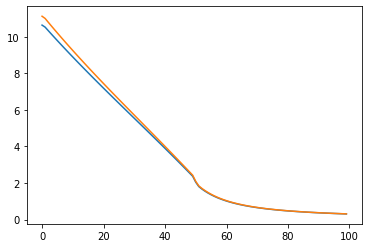

In [524]:
plt.plot(ems_dict[1e-5][:,-1])
plt.plot(ems_dict[1e-12][:,-1])

In [525]:
def compute_h_2d(ϕ, y_mat, b_mat, ems, args=(η, σy, γ1, γ2, ξₘ)):
    η, σy, γ1, γ2, ξₘ = args
    dΛ = γ1 + γ2*y_mat
    dy = y_mat[1,0] - y_mat[0,0]
    dϕdy = derivatives_2d(ϕ, 0, 1, dy)
    h_star = dϕdy + b_mat*(η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/(b_mat*ξₘ)
    return h_star

In [328]:
args=(η, σy, γ1, γ2, ξₘ)
h_2d_dict = dict()
for ℓ in [1e-12, 1e-5]:
    h_2d_dict[ℓ] = compute_h_2d(v_dict[ℓ], y_mat, b_mat, ems_dict[ℓ], args)

(0.0, 0.3)

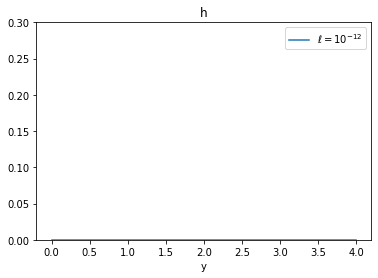

In [329]:
# plt.plot(y_grid[:], h_1d[:], label="no constraint")
plt.plot(y_mat[:,0], h_2d_dict[1e-12][:,-1], label="$ℓ = 10^{-12}$")
# plt.plot(y_mat[:,0], h_2d_dict[1e-5][:,-1], label="$ℓ = 10^{-5}$")
plt.legend()
plt.xlabel('y')
plt.title('h')
plt.ylim(0,0.3)
# plt.savefig("h_star.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

In [567]:
# 2 state HJB with constraints
θ = 1.86/1000
δ = 0.01
η = 0.032

ϵ = 1
# ℓ = 1e-12
ξₘ = 1000
σy = 1.2*θ

γ3_list = np.array([0, 2*0.0197, 2*0.3853])
π_p = np.array([1, 0, 0])
dΛ = γ1 + γ2*y_mat + π_p@γ3_list*(y_mat - ȳ)*(y_mat >ȳ)
ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
R_max = 9000

tol = 1e-7
ℓ = 1e-15
ℓ_step = 1e-15

ℓ_list = [ℓ, ℓ+ℓ_step]
# ℓ_list = np.linspace(1e-20,1e-10 , 10)
V_dict = dict()
E_dict = dict()

for ℓ_i in ℓ_list:
    episode = 0
    lhs_error = 1
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls

        print(np.min(ems))
        temp = v0_dy + b_mat*(η-1)*dΛ
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2+ b_mat*(η - 1)*ddΛ*σy**2
        b = temp*θ  - ℓ_i*θ 
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 0] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  ems*θ
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) +  b_mat*(η-1)*(dΛ*ems*θ + 1/2*ddΛ*ems**2*σy**2)\
        - ℓ_i*ems*θ - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    V_dict[ℓ_i] = v0

9.997912048545173
Episode 0: PDE Error: 0.001318976295; False Transient Error: 0.001194225073; Iterations: 1194; CG Error: 0.000000000091
End of PDE solver, takes time: 0.13068890571594238
6.754540849383817e-09
Episode 1: PDE Error: 0.001201093416; False Transient Error: 0.001109829308; Iterations: 734; CG Error: 0.000000000097
End of PDE solver, takes time: 0.08163738250732422
6.754540849383817e-09
Episode 2: PDE Error: 0.001114939722; False Transient Error: 0.001045846898; Iterations: 486; CG Error: 0.000000000099
End of PDE solver, takes time: 0.07760000228881836
6.754540848516455e-09
Episode 3: PDE Error: 0.001049136040; False Transient Error: 0.000994285251; Iterations: 347; CG Error: 0.000000000097
End of PDE solver, takes time: 0.039597511291503906
6.754540848516455e-09
Episode 4: PDE Error: 0.000996432020; False Transient Error: 0.000951101839; Iterations: 269; CG Error: 0.000000000095
End of PDE solver, takes time: 0.031224489212036133
6.754540848516455e-09
Episode 5: PDE Erro

Episode 49: PDE Error: 0.000371373656; False Transient Error: 0.000365311241; Iterations: 65; CG Error: 0.000000000095
End of PDE solver, takes time: 0.011847257614135742
6.754540847649093e-09
Episode 50: PDE Error: 0.000365318574; False Transient Error: 0.000359376784; Iterations: 65; CG Error: 0.000000000082
End of PDE solver, takes time: 0.009110689163208008
6.754540848516455e-09
Episode 51: PDE Error: 0.000359383715; False Transient Error: 0.000353558855; Iterations: 64; CG Error: 0.000000000095
End of PDE solver, takes time: 0.01160287857055664
6.754540848516455e-09
Episode 52: PDE Error: 0.000353565413; False Transient Error: 0.000347853968; Iterations: 64; CG Error: 0.000000000083
End of PDE solver, takes time: 0.008991479873657227
6.754540848516455e-09
Episode 53: PDE Error: 0.000347860177; False Transient Error: 0.000342258805; Iterations: 63; CG Error: 0.000000000098
End of PDE solver, takes time: 0.011217355728149414
6.754540849383817e-09
Episode 54: PDE Error: 0.00034226468

Episode 109: PDE Error: 0.000145142243; False Transient Error: 0.000142905794; Iterations: 51; CG Error: 0.000000000072
End of PDE solver, takes time: 0.009691238403320312
6.754540849383817e-09
Episode 110: PDE Error: 0.000142906354; False Transient Error: 0.000140702708; Iterations: 50; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0075986385345458984
6.754540849383817e-09
Episode 111: PDE Error: 0.000140703249; False Transient Error: 0.000138531865; Iterations: 50; CG Error: 0.000000000092
End of PDE solver, takes time: 0.009201288223266602
6.75454085111854e-09
Episode 112: PDE Error: 0.000138532387; False Transient Error: 0.000136392733; Iterations: 50; CG Error: 0.000000000088
End of PDE solver, takes time: 0.007501840591430664
6.75454085111854e-09
Episode 113: PDE Error: 0.000136393238; False Transient Error: 0.000134284794; Iterations: 50; CG Error: 0.000000000084
End of PDE solver, takes time: 0.00994563102722168
6.7545408528532636e-09
Episode 114: PDE Error: 0.00013

Episode 154: PDE Error: 0.000070695665; False Transient Error: 0.000069525025; Iterations: 46; CG Error: 0.000000000077
End of PDE solver, takes time: 0.007391929626464844
6.754540846781731e-09
Episode 155: PDE Error: 0.000069525159; False Transient Error: 0.000068371021; Iterations: 46; CG Error: 0.000000000074
End of PDE solver, takes time: 0.009380817413330078
6.754540848516455e-09
Episode 156: PDE Error: 0.000068371151; False Transient Error: 0.000067233284; Iterations: 46; CG Error: 0.000000000072
End of PDE solver, takes time: 0.009536981582641602
6.754540849383817e-09
Episode 157: PDE Error: 0.000067233410; False Transient Error: 0.000066111585; Iterations: 46; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0072062015533447266
6.754540850251178e-09
Episode 158: PDE Error: 0.000066111707; False Transient Error: 0.000065005701; Iterations: 45; CG Error: 0.000000000100
End of PDE solver, takes time: 0.006975650787353516
6.75454085111854e-09
Episode 159: PDE Error: 0.0000

Episode 201: PDE Error: 0.000030339090; False Transient Error: 0.000029743870; Iterations: 42; CG Error: 0.000000000089
End of PDE solver, takes time: 0.008417367935180664
6.754540830301858e-09
Episode 202: PDE Error: 0.000029743903; False Transient Error: 0.000029157412; Iterations: 42; CG Error: 0.000000000087
End of PDE solver, takes time: 0.006666660308837891
6.754540830301858e-09
Episode 203: PDE Error: 0.000029157445; False Transient Error: 0.000028579568; Iterations: 42; CG Error: 0.000000000084
End of PDE solver, takes time: 0.008385419845581055
6.754540829434497e-09
Episode 204: PDE Error: 0.000028579600; False Transient Error: 0.000028010224; Iterations: 42; CG Error: 0.000000000082
End of PDE solver, takes time: 0.006699800491333008
6.754540829434497e-09
Episode 205: PDE Error: 0.000028010255; False Transient Error: 0.000027449270; Iterations: 42; CG Error: 0.000000000080
End of PDE solver, takes time: 0.008231401443481445
6.754540830301858e-09
Episode 206: PDE Error: 0.0000

Episode 252: PDE Error: 0.000009057983; False Transient Error: 0.000008788461; Iterations: 39; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006609439849853516
6.754540871935222e-09
Episode 253: PDE Error: 0.000008788468; False Transient Error: 0.000008523369; Iterations: 39; CG Error: 0.000000000069
End of PDE solver, takes time: 0.00834512710571289
6.754540870200498e-09
Episode 254: PDE Error: 0.000008523376; False Transient Error: 0.000008262639; Iterations: 38; CG Error: 0.000000000099
End of PDE solver, takes time: 0.008400201797485352
6.7545408693331366e-09
Episode 255: PDE Error: 0.000008262646; False Transient Error: 0.000008006215; Iterations: 38; CG Error: 0.000000000096
End of PDE solver, takes time: 0.00634765625
6.754540864996328e-09
Episode 256: PDE Error: 0.000008006221; False Transient Error: 0.000007754036; Iterations: 38; CG Error: 0.000000000093
End of PDE solver, takes time: 0.006209850311279297
6.7545408597921575e-09
Episode 257: PDE Error: 0.0000077540

6.754540708871215e-09
Episode 305: PDE Error: 0.000004439645; False Transient Error: 0.000004442237; Iterations: 37; CG Error: 0.000000000098
End of PDE solver, takes time: 0.007569313049316406
6.754540704534406e-09
Episode 306: PDE Error: 0.000004442237; False Transient Error: 0.000004445186; Iterations: 38; CG Error: 0.000000000068
End of PDE solver, takes time: 0.006230354309082031
6.754540699330236e-09
Episode 307: PDE Error: 0.000004445186; False Transient Error: 0.000004447866; Iterations: 38; CG Error: 0.000000000070
End of PDE solver, takes time: 0.00747370719909668
6.754540698462874e-09
Episode 308: PDE Error: 0.000004447866; False Transient Error: 0.000004450698; Iterations: 38; CG Error: 0.000000000071
End of PDE solver, takes time: 0.006215333938598633
6.754540694993427e-09
Episode 309: PDE Error: 0.000004450698; False Transient Error: 0.000004453534; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.008077144622802734
6.754540692391342e-09
Episode 3

Episode 356: PDE Error: 0.000004926001; False Transient Error: 0.000004592337; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.006545305252075195
6.754540572695422e-09
Episode 357: PDE Error: 0.000004951611; False Transient Error: 0.000004595409; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.007579326629638672
6.7545405718280604e-09
Episode 358: PDE Error: 0.000004976254; False Transient Error: 0.000004598484; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.006269693374633789
6.754540569225975e-09
Episode 359: PDE Error: 0.000004999947; False Transient Error: 0.000004601561; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.007686138153076172
6.75454056662389e-09
Episode 360: PDE Error: 0.000005022705; False Transient Error: 0.000004604639; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.006226301193237305
6.754540565756528e-09
Episode 361: PDE Error: 0.0000

Episode 408: PDE Error: 0.000005282958; False Transient Error: 0.000004250801; Iterations: 38; CG Error: 0.000000000080
End of PDE solver, takes time: 0.008292913436889648
6.754540496367589e-09
Episode 409: PDE Error: 0.000005275804; False Transient Error: 0.000004235409; Iterations: 38; CG Error: 0.000000000080
End of PDE solver, takes time: 0.006350040435791016
6.754540496367589e-09
Episode 410: PDE Error: 0.000005268302; False Transient Error: 0.000004219806; Iterations: 38; CG Error: 0.000000000080
End of PDE solver, takes time: 0.006221294403076172
6.754540494632866e-09
Episode 411: PDE Error: 0.000005260459; False Transient Error: 0.000004203997; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.00757908821105957
6.754540492898142e-09
Episode 412: PDE Error: 0.000005252283; False Transient Error: 0.000004187988; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.00622105598449707
6.754540493765504e-09
Episode 413: PDE Error: 0.000005

Episode 460: PDE Error: 0.000004602099; False Transient Error: 0.000003281572; Iterations: 37; CG Error: 0.000000000089
End of PDE solver, takes time: 0.006361246109008789
6.754540468612014e-09
Episode 461: PDE Error: 0.000004585463; False Transient Error: 0.000003261481; Iterations: 37; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0074481964111328125
6.754540469479375e-09
Episode 462: PDE Error: 0.000004568776; False Transient Error: 0.000003241396; Iterations: 37; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0061190128326416016
6.754540469479375e-09
Episode 463: PDE Error: 0.000004552042; False Transient Error: 0.000003221320; Iterations: 37; CG Error: 0.000000000087
End of PDE solver, takes time: 0.008022069931030273
6.754540469479375e-09
Episode 464: PDE Error: 0.000004535263; False Transient Error: 0.000003201253; Iterations: 37; CG Error: 0.000000000087
End of PDE solver, takes time: 0.008082389831542969
6.754540469479375e-09
Episode 465: PDE Error: 0.00

Episode 513: PDE Error: 0.000003714747; False Transient Error: 0.000002271000; Iterations: 36; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0077342987060546875
6.754540484224525e-09
Episode 514: PDE Error: 0.000003698891; False Transient Error: 0.000002253691; Iterations: 36; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0060083866119384766
6.754540484224525e-09
Episode 515: PDE Error: 0.000003683095; False Transient Error: 0.000002236466; Iterations: 36; CG Error: 0.000000000087
End of PDE solver, takes time: 0.007390260696411133
6.754540485959248e-09
Episode 516: PDE Error: 0.000003667360; False Transient Error: 0.000002219324; Iterations: 36; CG Error: 0.000000000086
End of PDE solver, takes time: 0.005997419357299805
6.754540485959248e-09
Episode 517: PDE Error: 0.000003651686; False Transient Error: 0.000002202267; Iterations: 36; CG Error: 0.000000000086
End of PDE solver, takes time: 0.007420539855957031
6.75454048682661e-09
Episode 518: PDE Error: 0.000

Episode 567: PDE Error: 0.000002959745; False Transient Error: 0.000001462929; Iterations: 35; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0074024200439453125
6.754540510245377e-09
Episode 568: PDE Error: 0.000002947873; False Transient Error: 0.000001450437; Iterations: 35; CG Error: 0.000000000084
End of PDE solver, takes time: 0.005872964859008789
6.754540510245377e-09
Episode 569: PDE Error: 0.000002936080; False Transient Error: 0.000001438032; Iterations: 35; CG Error: 0.000000000083
End of PDE solver, takes time: 0.007269620895385742
6.754540510245377e-09
Episode 570: PDE Error: 0.000002924365; False Transient Error: 0.000001425716; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.005951642990112305
6.754540510245377e-09
Episode 571: PDE Error: 0.000002912728; False Transient Error: 0.000001413487; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0072481632232666016
6.754540511112739e-09
Episode 572: PDE Error: 0.00

Episode 622: PDE Error: 0.000002418049; False Transient Error: 0.000000897847; Iterations: 34; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0061283111572265625
6.754540500704398e-09
Episode 623: PDE Error: 0.000002410156; False Transient Error: 0.000000889680; Iterations: 34; CG Error: 0.000000000076
End of PDE solver, takes time: 0.007034778594970703
6.7545404989696745e-09
Episode 624: PDE Error: 0.000002402327; False Transient Error: 0.000000881580; Iterations: 34; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0058040618896484375
6.754540500704398e-09
Episode 625: PDE Error: 0.000002394561; False Transient Error: 0.000000873548; Iterations: 34; CG Error: 0.000000000074
End of PDE solver, takes time: 0.007004976272583008
6.7545404989696745e-09
Episode 626: PDE Error: 0.000002386857; False Transient Error: 0.000000865582; Iterations: 34; CG Error: 0.000000000073
End of PDE solver, takes time: 0.005827188491821289
6.754540498102313e-09
Episode 627: PDE Error: 0.

Episode 678: PDE Error: 0.000002063742; False Transient Error: 0.000000532791; Iterations: 32; CG Error: 0.000000000099
End of PDE solver, takes time: 0.005808830261230469
6.754540478152993e-09
Episode 679: PDE Error: 0.000002058845; False Transient Error: 0.000000527767; Iterations: 32; CG Error: 0.000000000098
End of PDE solver, takes time: 0.006822109222412109
6.7545404790203545e-09
Episode 680: PDE Error: 0.000002053990; False Transient Error: 0.000000522788; Iterations: 32; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0056111812591552734
6.754540479887716e-09
Episode 681: PDE Error: 0.000002049179; False Transient Error: 0.000000517854; Iterations: 32; CG Error: 0.000000000097
End of PDE solver, takes time: 0.006819009780883789
6.754540480755078e-09
Episode 682: PDE Error: 0.000002044411; False Transient Error: 0.000000512963; Iterations: 32; CG Error: 0.000000000096
End of PDE solver, takes time: 0.005628108978271484
6.754540479887716e-09
Episode 683: PDE Error: 0.00

Episode 736: PDE Error: 0.000001841774; False Transient Error: 0.000000305584; Iterations: 31; CG Error: 0.000000000085
End of PDE solver, takes time: 0.00574493408203125
6.754540497234951e-09
Episode 737: PDE Error: 0.000001838892; False Transient Error: 0.000000302640; Iterations: 31; CG Error: 0.000000000084
End of PDE solver, takes time: 0.006707668304443359
6.754540498102313e-09
Episode 738: PDE Error: 0.000001836036; False Transient Error: 0.000000299724; Iterations: 31; CG Error: 0.000000000084
End of PDE solver, takes time: 0.00560450553894043
6.754540498102313e-09
Episode 739: PDE Error: 0.000001833208; False Transient Error: 0.000000296835; Iterations: 31; CG Error: 0.000000000083
End of PDE solver, takes time: 0.006598949432373047
6.7545404989696745e-09
Episode 740: PDE Error: 0.000001830405; False Transient Error: 0.000000293973; Iterations: 31; CG Error: 0.000000000082
End of PDE solver, takes time: 0.005501508712768555
6.7545404989696745e-09
Episode 741: PDE Error: 0.0000

Episode 795: PDE Error: 0.000001710792; False Transient Error: 0.000000172001; Iterations: 30; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0067996978759765625
6.75454050677593e-09
Episode 796: PDE Error: 0.000001709146; False Transient Error: 0.000000170324; Iterations: 30; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0053713321685791016
6.75454050677593e-09
Episode 797: PDE Error: 0.000001707516; False Transient Error: 0.000000168664; Iterations: 30; CG Error: 0.000000000069
End of PDE solver, takes time: 0.00647425651550293
6.754540507643292e-09
Episode 798: PDE Error: 0.000001705901; False Transient Error: 0.000000167020; Iterations: 30; CG Error: 0.000000000068
End of PDE solver, takes time: 0.005372047424316406
6.75454050677593e-09
Episode 799: PDE Error: 0.000001704302; False Transient Error: 0.000000165391; Iterations: 30; CG Error: 0.000000000068
End of PDE solver, takes time: 0.007074832916259766
6.75454050677593e-09
Episode 800: PDE Error: 0.0000017

Episode 0: PDE Error: 0.001318976295; False Transient Error: 0.001194225073; Iterations: 1192; CG Error: 0.000000000098
End of PDE solver, takes time: 0.14545798301696777
6.754540848516455e-09
Episode 1: PDE Error: 0.001201093416; False Transient Error: 0.001109829308; Iterations: 733; CG Error: 0.000000000099
End of PDE solver, takes time: 0.08052396774291992
6.754540849383817e-09
Episode 2: PDE Error: 0.001114939722; False Transient Error: 0.001045846898; Iterations: 486; CG Error: 0.000000000099
End of PDE solver, takes time: 0.05404472351074219
6.754540850251178e-09
Episode 3: PDE Error: 0.001049136040; False Transient Error: 0.000994285251; Iterations: 347; CG Error: 0.000000000097
End of PDE solver, takes time: 0.03929638862609863
6.754540850251178e-09
Episode 4: PDE Error: 0.000996432020; False Transient Error: 0.000951101839; Iterations: 269; CG Error: 0.000000000095
End of PDE solver, takes time: 0.031124114990234375
6.754540849383817e-09
Episode 5: PDE Error: 0.000952566506; 

Episode 50: PDE Error: 0.000365318574; False Transient Error: 0.000359376784; Iterations: 65; CG Error: 0.000000000082
End of PDE solver, takes time: 0.009420394897460938
6.754540849383817e-09
Episode 51: PDE Error: 0.000359383715; False Transient Error: 0.000353558855; Iterations: 64; CG Error: 0.000000000095
End of PDE solver, takes time: 0.009014368057250977
6.754540849383817e-09
Episode 52: PDE Error: 0.000353565413; False Transient Error: 0.000347853968; Iterations: 64; CG Error: 0.000000000083
End of PDE solver, takes time: 0.009284257888793945
6.754540849383817e-09
Episode 53: PDE Error: 0.000347860177; False Transient Error: 0.000342258805; Iterations: 63; CG Error: 0.000000000098
End of PDE solver, takes time: 0.010945558547973633
6.754540849383817e-09
Episode 54: PDE Error: 0.000342264688; False Transient Error: 0.000336770203; Iterations: 63; CG Error: 0.000000000086
End of PDE solver, takes time: 0.008885622024536133
6.754540849383817e-09
Episode 55: PDE Error: 0.0003367757

Episode 94: PDE Error: 0.000183023476; False Transient Error: 0.000180220680; Iterations: 53; CG Error: 0.000000000081
End of PDE solver, takes time: 0.008044719696044922
6.754540848516455e-09
Episode 95: PDE Error: 0.000180221643; False Transient Error: 0.000177461473; Iterations: 53; CG Error: 0.000000000076
End of PDE solver, takes time: 0.009635448455810547
6.754540849383817e-09
Episode 96: PDE Error: 0.000177462401; False Transient Error: 0.000174744086; Iterations: 52; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0077054500579833984
6.754540848516455e-09
Episode 97: PDE Error: 0.000174744980; False Transient Error: 0.000172067770; Iterations: 52; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0077075958251953125
6.754540847649093e-09
Episode 98: PDE Error: 0.000172068631; False Transient Error: 0.000169431793; Iterations: 52; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0077168941497802734
6.754540847649093e-09
Episode 99: PDE Error: 0.0001694

Episode 143: PDE Error: 0.000084730448; False Transient Error: 0.000083361807; Iterations: 47; CG Error: 0.000000000076
End of PDE solver, takes time: 0.007674694061279297
6.754540840710199e-09
Episode 144: PDE Error: 0.000083361992; False Transient Error: 0.000082012681; Iterations: 47; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0071868896484375
6.7545408398428375e-09
Episode 145: PDE Error: 0.000082012861; False Transient Error: 0.000080682599; Iterations: 47; CG Error: 0.000000000071
End of PDE solver, takes time: 0.007288932800292969
6.7545408398428375e-09
Episode 146: PDE Error: 0.000080682774; False Transient Error: 0.000079371287; Iterations: 47; CG Error: 0.000000000069
End of PDE solver, takes time: 0.007386684417724609
6.7545408398428375e-09
Episode 147: PDE Error: 0.000079371456; False Transient Error: 0.000078078473; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.007079601287841797
6.754540840710199e-09
Episode 148: PDE Error: 0.000

Episode 194: PDE Error: 0.000034759730; False Transient Error: 0.000034100066; Iterations: 43; CG Error: 0.000000000074
End of PDE solver, takes time: 0.006972074508666992
6.754540837240752e-09
Episode 195: PDE Error: 0.000034100107; False Transient Error: 0.000033450019; Iterations: 43; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006760597229003906
6.754540835506029e-09
Episode 196: PDE Error: 0.000033450060; False Transient Error: 0.000032809421; Iterations: 43; CG Error: 0.000000000070
End of PDE solver, takes time: 0.006759166717529297
6.754540834638667e-09
Episode 197: PDE Error: 0.000032809460; False Transient Error: 0.000032178148; Iterations: 43; CG Error: 0.000000000068
End of PDE solver, takes time: 0.006734132766723633
6.7545408329039436e-09
Episode 198: PDE Error: 0.000032178186; False Transient Error: 0.000031556076; Iterations: 42; CG Error: 0.000000000097
End of PDE solver, takes time: 0.006640195846557617
6.75454083116922e-09
Episode 199: PDE Error: 0.0000

Episode 249: PDE Error: 0.000009893674; False Transient Error: 0.000009610517; Iterations: 39; CG Error: 0.000000000078
End of PDE solver, takes time: 0.007810831069946289
6.7545408762720305e-09
Episode 250: PDE Error: 0.000009610525; False Transient Error: 0.000009331974; Iterations: 39; CG Error: 0.000000000076
End of PDE solver, takes time: 0.006333827972412109
6.754540875404669e-09
Episode 251: PDE Error: 0.000009331982; False Transient Error: 0.000009057976; Iterations: 39; CG Error: 0.000000000074
End of PDE solver, takes time: 0.006505012512207031
6.754540874537307e-09
Episode 252: PDE Error: 0.000009057983; False Transient Error: 0.000008788461; Iterations: 39; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006334543228149414
6.754540873669945e-09
Episode 253: PDE Error: 0.000008788468; False Transient Error: 0.000008523369; Iterations: 39; CG Error: 0.000000000069
End of PDE solver, takes time: 0.006320476531982422
6.7545408728025835e-09
Episode 254: PDE Error: 0.00

Episode 307: PDE Error: 0.000004445186; False Transient Error: 0.000004447866; Iterations: 38; CG Error: 0.000000000070
End of PDE solver, takes time: 0.006474018096923828
6.754540698462874e-09
Episode 308: PDE Error: 0.000004447866; False Transient Error: 0.000004450698; Iterations: 38; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0062329769134521484
6.754540694993427e-09
Episode 309: PDE Error: 0.000004450698; False Transient Error: 0.000004453534; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006273746490478516
6.754540693258704e-09
Episode 310: PDE Error: 0.000004453534; False Transient Error: 0.000004456163; Iterations: 38; CG Error: 0.000000000074
End of PDE solver, takes time: 0.006236553192138672
6.7545406906566186e-09
Episode 311: PDE Error: 0.000004456164; False Transient Error: 0.000004459152; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.006313323974609375
6.754540688054533e-09
Episode 312: PDE Error: 0.00

6.754540560552358e-09
Episode 364: PDE Error: 0.000005104697; False Transient Error: 0.000004614213; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.00621795654296875
6.754540557950273e-09
Episode 365: PDE Error: 0.000005123011; False Transient Error: 0.000004615237; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.006224632263183594
6.754540556215549e-09
Episode 366: PDE Error: 0.000005140482; False Transient Error: 0.000004615706; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0062160491943359375
6.7545405553481874e-09
Episode 367: PDE Error: 0.000005157123; False Transient Error: 0.000004615630; Iterations: 38; CG Error: 0.000000000091
End of PDE solver, takes time: 0.00630640983581543
6.754540553613464e-09
Episode 368: PDE Error: 0.000005172950; False Transient Error: 0.000004615019; Iterations: 38; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0062181949615478516
6.754540552746102e-09
Episode

6.754540487693972e-09
Episode 420: PDE Error: 0.000005175851; False Transient Error: 0.000004053407; Iterations: 38; CG Error: 0.000000000076
End of PDE solver, takes time: 0.006229400634765625
6.754540485959248e-09
Episode 421: PDE Error: 0.000005165031; False Transient Error: 0.000004035853; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.006229877471923828
6.754540485959248e-09
Episode 422: PDE Error: 0.000005153954; False Transient Error: 0.000004018153; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.006219625473022461
6.754540485091887e-09
Episode 423: PDE Error: 0.000005142626; False Transient Error: 0.000004000312; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0062601566314697266
6.754540483357163e-09
Episode 424: PDE Error: 0.000005131055; False Transient Error: 0.000003982337; Iterations: 38; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0062236785888671875
6.754540483357163e-09
Episod

Episode 477: PDE Error: 0.000004314565; False Transient Error: 0.000002942416; Iterations: 37; CG Error: 0.000000000079
End of PDE solver, takes time: 0.006326913833618164
6.7545404720814606e-09
Episode 478: PDE Error: 0.000004297493; False Transient Error: 0.000002922735; Iterations: 37; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0061893463134765625
6.7545404720814606e-09
Episode 479: PDE Error: 0.000004280421; False Transient Error: 0.000002903096; Iterations: 37; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0062067508697509766
6.7545404720814606e-09
Episode 480: PDE Error: 0.000004263352; False Transient Error: 0.000002883502; Iterations: 37; CG Error: 0.000000000077
End of PDE solver, takes time: 0.006097078323364258
6.7545404720814606e-09
Episode 481: PDE Error: 0.000004246288; False Transient Error: 0.000002863954; Iterations: 37; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0062487125396728516
6.7545404720814606e-09
Episode 482: PDE Error

Episode 535: PDE Error: 0.000003381030; False Transient Error: 0.000001910137; Iterations: 36; CG Error: 0.000000000074
End of PDE solver, takes time: 0.006409168243408203
6.754540500704398e-09
Episode 536: PDE Error: 0.000003366670; False Transient Error: 0.000001894755; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.006009101867675781
6.754540500704398e-09
Episode 537: PDE Error: 0.000003352385; False Transient Error: 0.000001879464; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.006014108657836914
6.754540500704398e-09
Episode 538: PDE Error: 0.000003338175; False Transient Error: 0.000001864263; Iterations: 36; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006050825119018555
6.75454050157176e-09
Episode 539: PDE Error: 0.000003324040; False Transient Error: 0.000001849153; Iterations: 36; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006036281585693359
6.75454050157176e-09
Episode 540: PDE Error: 0.000003

6.754540516316909e-09
Episode 594: PDE Error: 0.000002666291; False Transient Error: 0.000001155645; Iterations: 34; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0059452056884765625
6.754540514582186e-09
Episode 595: PDE Error: 0.000002656477; False Transient Error: 0.000001145418; Iterations: 34; CG Error: 0.000000000098
End of PDE solver, takes time: 0.005903482437133789
6.754540514582186e-09
Episode 596: PDE Error: 0.000002646736; False Transient Error: 0.000001135271; Iterations: 34; CG Error: 0.000000000097
End of PDE solver, takes time: 0.005964756011962891
6.754540513714824e-09
Episode 597: PDE Error: 0.000002637068; False Transient Error: 0.000001125203; Iterations: 34; CG Error: 0.000000000096
End of PDE solver, takes time: 0.00582575798034668
6.754540513714824e-09
Episode 598: PDE Error: 0.000002627472; False Transient Error: 0.000001115212; Iterations: 34; CG Error: 0.000000000095
End of PDE solver, takes time: 0.005966663360595703
6.754540513714824e-09
Episode 

Episode 653: PDE Error: 0.000002201274; False Transient Error: 0.000000674128; Iterations: 33; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0060160160064697266
6.754540489428695e-09
Episode 654: PDE Error: 0.000002195180; False Transient Error: 0.000000667854; Iterations: 33; CG Error: 0.000000000084
End of PDE solver, takes time: 0.005834341049194336
6.754540488561334e-09
Episode 655: PDE Error: 0.000002189138; False Transient Error: 0.000000661636; Iterations: 33; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0068950653076171875
6.754540488561334e-09
Episode 656: PDE Error: 0.000002183149; False Transient Error: 0.000000655471; Iterations: 33; CG Error: 0.000000000082
End of PDE solver, takes time: 0.005734443664550781
6.75454048682661e-09
Episode 657: PDE Error: 0.000002177210; False Transient Error: 0.000000649361; Iterations: 33; CG Error: 0.000000000081
End of PDE solver, takes time: 0.005727052688598633
6.754540487693972e-09
Episode 658: PDE Error: 0.000

Episode 714: PDE Error: 0.000001912463; False Transient Error: 0.000000377812; Iterations: 32; CG Error: 0.000000000070
End of PDE solver, takes time: 0.005921840667724609
6.754540489428695e-09
Episode 715: PDE Error: 0.000001908928; False Transient Error: 0.000000374197; Iterations: 32; CG Error: 0.000000000070
End of PDE solver, takes time: 0.005667209625244141
6.754540489428695e-09
Episode 716: PDE Error: 0.000001905426; False Transient Error: 0.000000370616; Iterations: 32; CG Error: 0.000000000069
End of PDE solver, takes time: 0.005651712417602539
6.754540489428695e-09
Episode 717: PDE Error: 0.000001901956; False Transient Error: 0.000000367068; Iterations: 32; CG Error: 0.000000000068
End of PDE solver, takes time: 0.00567626953125
6.754540490296057e-09
Episode 718: PDE Error: 0.000001898517; False Transient Error: 0.000000363553; Iterations: 32; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0056438446044921875
6.754540490296057e-09
Episode 719: PDE Error: 0.0000018

Episode 778: PDE Error: 0.000001741333; False Transient Error: 0.000000203121; Iterations: 30; CG Error: 0.000000000083
End of PDE solver, takes time: 0.005730390548706055
6.7545405085106536e-09
Episode 779: PDE Error: 0.000001739395; False Transient Error: 0.000000201147; Iterations: 30; CG Error: 0.000000000082
End of PDE solver, takes time: 0.00543665885925293
6.7545405085106536e-09
Episode 780: PDE Error: 0.000001737477; False Transient Error: 0.000000199191; Iterations: 30; CG Error: 0.000000000081
End of PDE solver, takes time: 0.005467653274536133
6.7545405085106536e-09
Episode 781: PDE Error: 0.000001735576; False Transient Error: 0.000000197254; Iterations: 30; CG Error: 0.000000000081
End of PDE solver, takes time: 0.00646662712097168
6.7545405085106536e-09
Episode 782: PDE Error: 0.000001733693; False Transient Error: 0.000000195335; Iterations: 30; CG Error: 0.000000000080
End of PDE solver, takes time: 0.005399942398071289
6.7545405085106536e-09
Episode 783: PDE Error: 0.0

Episode 843: PDE Error: 0.000001647253; False Transient Error: 0.000000107344; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0055332183837890625
6.754540490296057e-09
Episode 844: PDE Error: 0.000001646218; False Transient Error: 0.000000106292; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0052623748779296875
6.754540490296057e-09
Episode 845: PDE Error: 0.000001645194; False Transient Error: 0.000000105251; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.005286216735839844
6.754540490296057e-09
Episode 846: PDE Error: 0.000001644179; False Transient Error: 0.000000104220; Iterations: 28; CG Error: 0.000000000095
End of PDE solver, takes time: 0.005223751068115234
6.754540490296057e-09
Episode 847: PDE Error: 0.000001643175; False Transient Error: 0.000000103199; Iterations: 28; CG Error: 0.000000000094
End of PDE solver, takes time: 0.005237579345703125
6.754540490296057e-09
Episode 848: PDE Error: 0.00

Text(0.5, 1.0, 'ϕ')

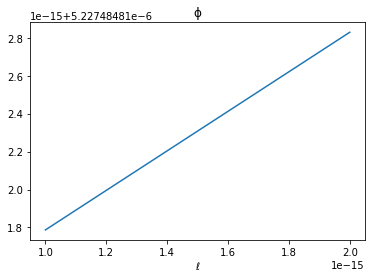

In [568]:
V_list = list()
for ℓ_i in ℓ_list:
    V_list.append(V_dict[ℓ_i][12, -1]/9000 )
plt.plot(ℓ_list,  np.array(V_list)+ℓ_list )
# plt.plot(ℓ_list, -ℓ_list)
plt.xlabel('ℓ')
plt.title('ϕ')

In [569]:
V_dict[ℓ_list[0]][25, -1]/9000  , V_dict[ℓ_list[1]][25, -1]/9000, 

(4.682297381825007e-06, 4.682297381881286e-06)

In [570]:
V_list

[5.2274848107870834e-06, 5.2274848108288184e-06]

In [571]:
ℓ_list

[1e-15, 2e-15]

$$
 V( \ell)  = \min_{\ell \geqslant 0} \tilde V(\ell) + \ell r
$$

$$
 - \frac{\partial V}{\partial \ell} (\ell) = r
$$

In [572]:
ℓ_list[1] - ℓ_list[0]

1e-15

Text(0.5, 0, 'y')

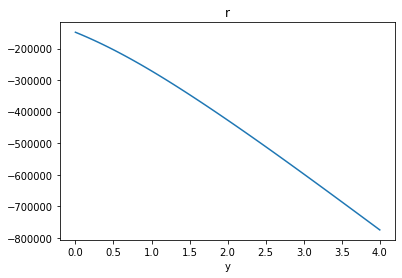

In [573]:
plt.plot(y_mat[:,0], - (V_dict[ℓ_list[1]][:,-1] - V_dict[ℓ_list[0]][:,-1])/ℓ_step/θ)
plt.title('r')
plt.xlabel('y')
# plt.savefig("r.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

In [574]:
- (V_dict[ℓ_list[1]][12,-1] - V_dict[ℓ_list[0]][12,-1])/ℓ_step

-375.61620480630603

Text(0.5, 0, 'y')

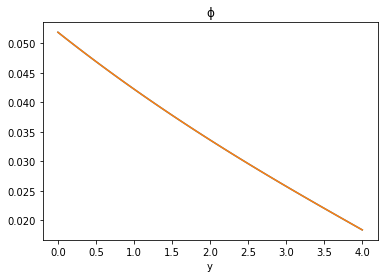

In [575]:
# plt.plot(y_mat[:,0], V_dict[0][:,-1])
plt.plot(y_mat[:,0], V_dict[ℓ][:,-1])
plt.plot(y_mat[:,0], V_dict[ℓ+ℓ_step][:,-1])
plt.title('ϕ')
plt.xlabel('y')

In [537]:
5/9000, 20/9000

(0.0005555555555555556, 0.0022222222222222222)